# Do DL models and training environments have an impact on the energy consumption of computer vision training?

Author: Santiago del Rey

## Import libraries

In [2]:
import os
import sys
import itertools

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import scikit_posthocs as sp
import seaborn as sns
from cliffs_delta import cliffs_delta
from scipy import stats

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.data.analysis import (
    test_assumptions,
    boxplot,
    barplot,
    eta_squared,
    is_pareto_efficient,
    print_improvement,
)
from src.environment import FIGURES_DIR, METRICS_DIR
from src.data.preprocessing import MJOULES_TO_JOULES, HOURS_TO_MILISECONDS

SAVE_FIGS = True
FIGURES_FORMAT = "png"

sns.set_theme(palette="colorblind", color_codes=True)

%matplotlib inline

mpl.rcParams["font.family"] = "serif"
mpl.rcParams["font.serif"] = "Times New Roman"
mpl.rcParams["font.weight"] = "bold"
mpl.rcParams["font.size"] = 12
mpl.rcParams["figure.autolayout"] = "true"
mpl.rcParams["axes.grid"] = "true"
mpl.rcParams["grid.color"] = "gray"

2023-12-20 14:55:01.831937: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-20 14:55:01.940574: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2023-12-20 14:55:02.328091: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-20 14:55:02.328158: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-20 14:55:02.328163: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
2023-12-20 14:55:02.963533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-20 14:55:02.979018: I tensorflow

## Load the dataset

In [3]:
analysis_df = pd.read_parquet(os.path.join(METRICS_DIR, "processed", "dl-training-energy-consumption-dataset.gzip"))
print(analysis_df.shape)
analysis_df.head()

(369, 31)


,training environment,architecture,run,training duration (h),gpu model,gpu working time (h),gpu usage (%),gpu memory working time (h),gpu memory usage,average memory used (MB),...,validation size,batch size,GFLOPs,accuracy,precision,recall,AUC,trained epochs,total seen images,f1-score
0,Cloud,mobilenet_v2,0,0.734750,NVIDIA GeForce RTX 3090,0.168889,23.004162,0.061686,0.084022,23648.749527,...,10203,32,0.064028,0.975629,0.959826,0.993169,0.995675,88,2987776,0.976213
1,Cloud,mobilenet_v2,1,0.795914,NVIDIA GeForce RTX 3090,0.182600,22.960531,0.066108,0.083126,23657.000000,...,10203,32,0.064028,0.971108,0.957560,0.986339,0.992465,92,3123584,0.971736
2,Cloud,mobilenet_v2,2,0.471948,NVIDIA GeForce RTX 3090,0.105261,22.316843,0.038169,0.080925,23657.000000,...,10203,32,0.064028,0.960397,0.956488,0.965262,0.987073,55,1867360,0.960855
3,Cloud,mobilenet_v2,3,0.634343,NVIDIA GeForce RTX 3090,0.144261,22.758107,0.052850,0.083374,23657.000000,...,10203,32,0.064028,0.974941,0.962921,0.988290,0.994777,74,2512448,0.975441
4,Cloud,mobilenet_v2,4,0.662703,NVIDIA GeForce RTX 3090,0.150069,22.661493,0.053986,0.081523,23657.000000,...,10203,32,0.064028,0.968553,0.957524,0.981070,0.990629,76,2580352,0.969154


## Data analysis

In [4]:
TRAIN_STRATEGIES = ["Local N", "Local ML", "Cloud"]
MARKERS = {
    "MobileNet V2": "o",
    "NASNet Mobile": "v",
    "Xception": "^",
    "ResNet50": "X",
    "VGG16": "P",
}
COLORS = {"Local N": "b", "Local ML": "orange", "Cloud": "g"}
ARCHITECTURE_LABELS = ["MobileNet\nV2", "NASNet\nMobile", "ResNet50", "VGG16", "Xception"]

analysis_df.rename(
    columns={
        "energy (MJ)": "energy",
        "gpu usage (%)": "gpu_usage",
        "average temperature (Celsius)": "temperature",
        "emissions (tCO2e)": "emissions",
    },
    inplace=True,
)

analysis_df.replace(
    {
        "Local Normal User": "Local N",
        "Local ML Engineer/Gamer": "Local ML",
        "mobilenet_v2": "MobileNet V2",
        "nasnet_mobile": "NASNet Mobile",
        "xception": "Xception",
        "resnet50": "ResNet50",
        "vgg16": "VGG16",
    },
    inplace=True,
)

analysis_df["raw energy"] = analysis_df.energy.copy()
analysis_df["energy"] = analysis_df["raw energy"] * MJOULES_TO_JOULES / analysis_df["total seen images"]
analysis_df["normalized duration"] = (
    analysis_df["training duration (h)"] * HOURS_TO_MILISECONDS / analysis_df["total seen images"]
)

In [5]:
local_n_mobilenet = analysis_df.query("`training environment` == 'Local N' & architecture == 'MobileNet V2'")
local_n_nasnet = analysis_df.query("`training environment` == 'Local N' & architecture == 'NASNet Mobile'")

local_ml_mobilenet = analysis_df.query("`training environment` == 'Local ML' & architecture == 'MobileNet V2'")
local_ml_nasnet = analysis_df.query("`training environment` == 'Local ML' & architecture == 'NASNet Mobile'")
local_ml_xception = analysis_df.query("`training environment` == 'Local ML' & architecture == 'Xception'")
local_ml_resnet50 = analysis_df.query("`training environment` == 'Local ML' & architecture == 'ResNet50'")
local_ml_vgg16 = analysis_df.query("`training environment` == 'Local ML' & architecture == 'VGG16'")


cloud_mobilenet = analysis_df.query("`training environment` == 'Cloud' & architecture == 'MobileNet V2'")
cloud_nasnet = analysis_df.query("`training environment` == 'Cloud' & architecture == 'NASNet Mobile'")
cloud_xception = analysis_df.query("`training environment` == 'Cloud' & architecture == 'Xception'")
cloud_resnet50 = analysis_df.query("`training environment` == 'Cloud' & architecture == 'ResNet50'")
cloud_vgg16 = analysis_df.query("`training environment` == 'Cloud' & architecture == 'VGG16'")

### Look for outliers

#### Energy

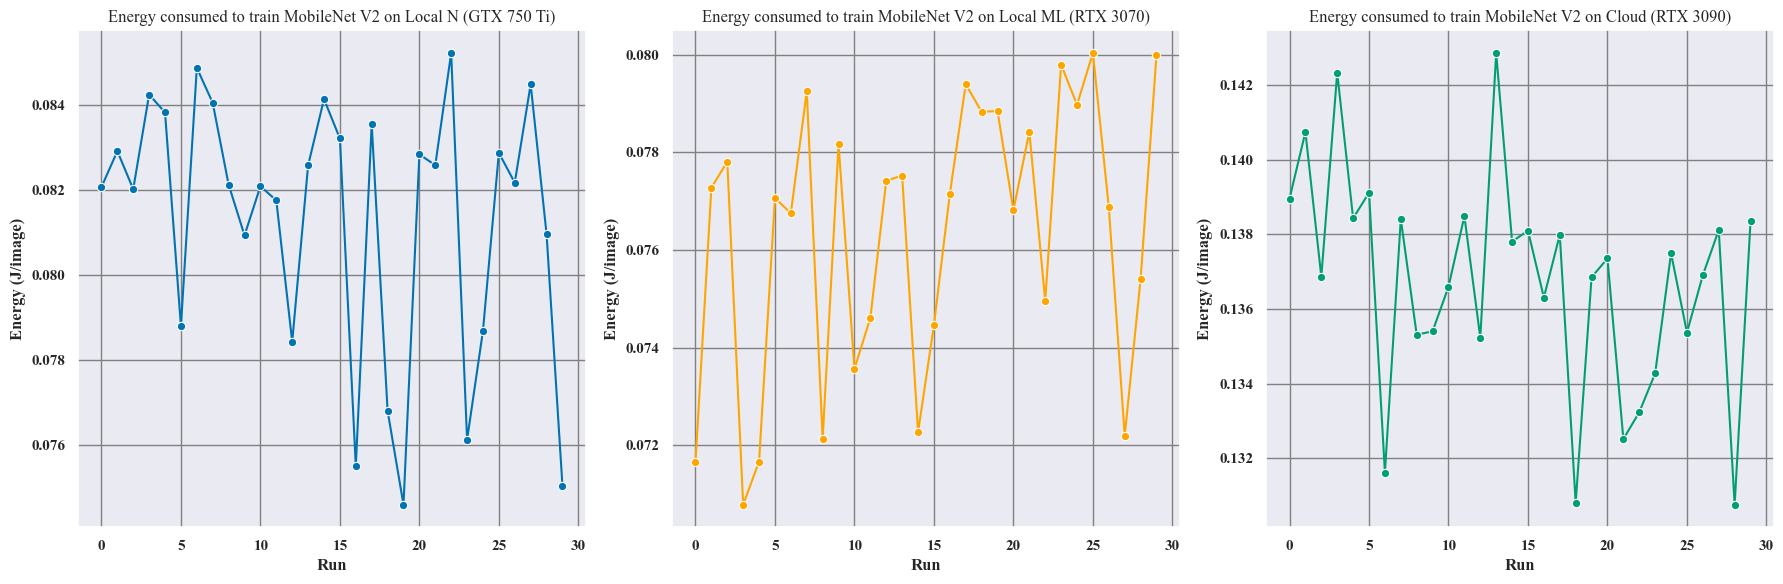

In [6]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 6))
ax = sns.lineplot(data=local_n_mobilenet, x="run", y="energy", ax=ax0, marker="o", color=COLORS["Local N"])
ax.set_ylabel("Energy (J/image)")
ax.set_xlabel("Run")
ax.set_title("Energy consumed to train MobileNet V2 on Local N (GTX 750 Ti)")

ax = sns.lineplot(data=local_ml_mobilenet.iloc[:30], x="run", y="energy", ax=ax1, marker="o", color=COLORS["Local ML"])
ax.set_ylabel("Energy (J/image)")
ax.set_xlabel("Run")
ax.set_title("Energy consumed to train MobileNet V2 on Local ML (RTX 3070)")

ax = sns.lineplot(data=cloud_mobilenet, x="run", y="energy", ax=ax2, marker="o", color=COLORS["Cloud"])
ax.set_ylabel("Energy (J/image)")
ax.set_xlabel("Run")
ax.set_title("Energy consumed to train MobileNet V2 on Cloud (RTX 3090)")

fig.tight_layout()

##### Cloud
Looking at the boxplots we observe some extreme outliers. In this case in the NASNet, Xception and VGG16 architectures.

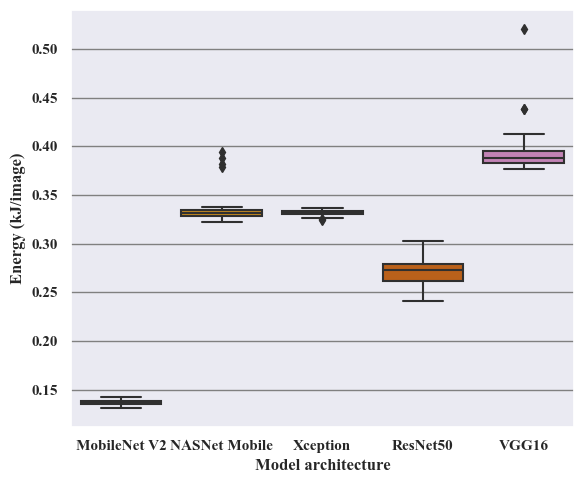

In [7]:
boxplot(
    pd.concat([cloud_mobilenet, cloud_nasnet, cloud_xception, cloud_resnet50, cloud_vgg16]),
    x="architecture",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (kJ/image)",
    figname=f"cloud-energy-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

We manually inspect the outliers to see if they should be removed or not.

In [8]:
sorted_cloud_nasnet = cloud_nasnet.sort_values(by="energy", ascending=False)
pd.concat([sorted_cloud_nasnet.iloc[:5], sorted_cloud_nasnet.iloc[-5:]])[
    [
        "run",
        "training duration (h)",
        "trained epochs",
        "gpu_usage",
        "temperature",
        "raw energy",
        "energy",
        "normalized duration",
    ]
]

,run,training duration (h),trained epochs,gpu_usage,temperature,raw energy,energy,normalized duration
31,1,1.688808,85,34.553248,56.873228,1.136436,0.393786,2.106680
32,2,1.157140,58,33.389476,56.491831,0.763600,0.387769,2.115412
30,0,1.374044,72,35.466208,57.039255,0.932775,0.381574,2.023510
33,3,1.300914,68,35.315879,56.850823,0.875249,0.379103,2.028508
50,20,1.276295,80,42.727491,54.606497,0.917004,0.337611,1.691602
58,28,1.066614,67,41.666406,54.118153,0.746123,0.327997,1.687989
38,8,0.940801,60,41.771141,54.534595,0.667462,0.327650,1.662584
45,15,0.849968,54,41.209493,54.024550,0.593168,0.323533,1.668960
59,29,1.297676,86,44.710763,54.884863,0.944097,0.323335,1.599945
34,4,1.135511,76,44.778976,55.004411,0.831465,0.322229,1.584217


In [9]:
sorted_cloud_xception = cloud_xception.sort_values(by="energy", ascending=False)
pd.concat([sorted_cloud_xception.iloc[:10], sorted_cloud_xception.iloc[-10:]])[
    [
        "run",
        "training duration (h)",
        "trained epochs",
        "gpu_usage",
        "temperature",
        "raw energy",
        "energy",
        "normalized duration",
    ]
]

,run,training duration (h),trained epochs,gpu_usage,temperature,raw energy,energy,normalized duration
129,9,1.052702,88,59.246430,62.670809,1.007082,0.337068,1.268410
138,18,1.132989,96,60.091288,62.834601,1.096400,0.336382,1.251387
137,17,0.812879,68,58.654241,62.410739,0.774888,0.335633,1.267518
120,0,1.092949,93,60.305775,62.979649,1.059447,0.335530,1.246103
131,11,1.150497,98,60.352102,62.981634,1.116304,0.335499,1.244792
132,12,0.968240,81,58.961771,62.564530,0.922121,0.335303,1.267463
139,19,0.954149,81,59.355478,62.699883,0.918816,0.334101,1.249017
125,5,0.846973,72,60.184358,62.812356,0.816533,0.334023,1.247310
146,26,0.915743,78,60.079635,62.820365,0.884068,0.333830,1.244848
148,28,0.896288,76,59.480435,62.734783,0.860969,0.333663,1.250464


In [10]:
sorted_cloud_vgg16 = cloud_vgg16.sort_values(by="energy", ascending=False)
pd.concat([sorted_cloud_vgg16.iloc[:5], sorted_cloud_vgg16.iloc[-5:]])[
    [
        "run",
        "training duration (h)",
        "trained epochs",
        "gpu_usage",
        "temperature",
        "raw energy",
        "energy",
        "normalized duration",
    ]
]

,run,training duration (h),trained epochs,gpu_usage,temperature,raw energy,energy,normalized duration
116,26,1.179458,81,94.128568,64.980656,1.431716,0.520603,1.543955
114,24,0.912780,74,91.826882,64.651935,1.101893,0.438574,1.307891
94,4,0.806481,66,92.689548,64.973784,0.982598,0.438497,1.295649
99,9,0.850699,73,91.527469,64.735448,1.023863,0.413099,1.235635
93,3,0.785654,68,91.613314,64.810552,0.948618,0.410882,1.225066
115,25,0.764706,71,90.433248,64.714805,0.920432,0.381828,1.142019
98,8,0.807547,75,89.986566,64.638305,0.972151,0.381775,1.141679
91,1,0.700975,66,89.948016,64.735714,0.845963,0.377522,1.126148
103,13,0.658459,62,89.983101,64.622729,0.793311,0.376865,1.126093
101,11,0.743549,70,90.426861,64.789375,0.895275,0.376698,1.126285


In [11]:
cloud_vgg16_no_energy_outliers = sorted_cloud_vgg16.iloc[1:]
print("Cloud VGG16 remaining samples:", cloud_vgg16_no_energy_outliers.shape[0])

Cloud VGG16 remaining samples: 29


After inspecting the data, we decide to remove the extreme outliers VGG16 architecture.

##### Local ML
Again, we observe some outliers. In this case in the Xception architecture.

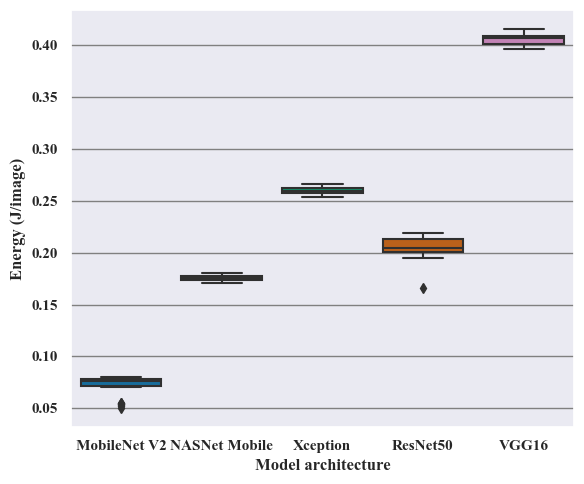

In [12]:
boxplot(
    pd.concat(
        [
            local_ml_mobilenet,
            local_ml_nasnet,
            local_ml_xception,
            local_ml_resnet50,
            local_ml_vgg16,
        ]
    ),
    x="architecture",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (J/image)",
    figname=f"local-v2-energy-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

We proceed to review the outliers to decide whether to remove them or not. Looking at the data, it seems the outliers are a natural outcome of the training process rather than a measurement error or sampling problems.

In [13]:
local_ml_xception.sort_values(by="energy", ascending=False)[
    [
        "run",
        "training duration (h)",
        "trained epochs",
        "gpu_usage",
        "temperature",
        "raw energy",
        "energy",
        "normalized duration",
    ]
]

,run,training duration (h),trained epochs,gpu_usage,temperature,raw energy,energy,normalized duration
368,29,1.139417,87,92.827191,64.843300,0.785294,0.265857,1.388675
367,28,1.099361,84,93.179863,64.800911,0.756308,0.265188,1.387708
363,24,1.023988,79,93.256654,64.736828,0.706121,0.263261,1.374374
341,2,0.889346,69,92.811445,65.683240,0.615137,0.262577,1.366654
343,4,0.862363,67,92.833280,65.755240,0.596593,0.262264,1.364747
366,27,0.918272,71,92.964264,64.763174,0.632158,0.262242,1.371355
350,11,0.919678,70,93.107650,64.706078,0.623155,0.262200,1.393076
361,22,0.956943,74,92.972973,64.576286,0.658651,0.262155,1.371170
340,1,0.874325,68,92.970420,65.704517,0.604991,0.262044,1.363330
342,3,0.822583,64,92.774172,65.725152,0.568017,0.261406,1.362815


##### Local vs. Cloud
For the Local vs. Cloud analysis of energy, we consider the outliers in the Local ML to be have a negligible difference compared to the rest of the samples in the group. Therefore, we do not remove any outliers.

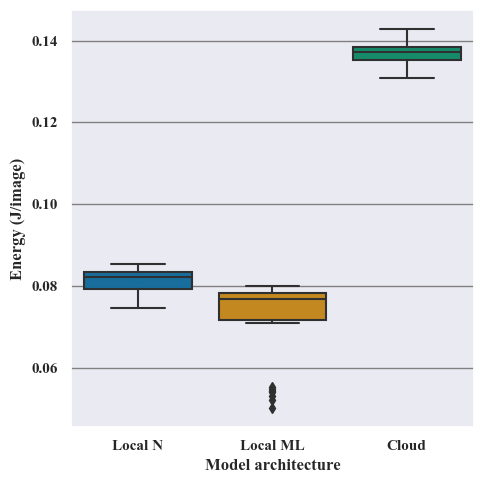

In [14]:
boxplot(
    pd.concat([local_n_mobilenet, local_ml_mobilenet, cloud_mobilenet]),
    x="training environment",
    y="energy",
    xlabel="Model architecture",
    ylabel="Energy (J/image)",
    figname=f"local-vs-cloud-energy-boxplot.{FIGURES_FORMAT}",
)

#### GPU usage
##### Cloud

For the GPU usage we observe the presence of outliers in the MobileNet V2, NASNet Mobile, ResNet50 and VGG16 measurements. However, we only remove the outliers of the NASNet and ResNet50 architectures, which are the most extreme.

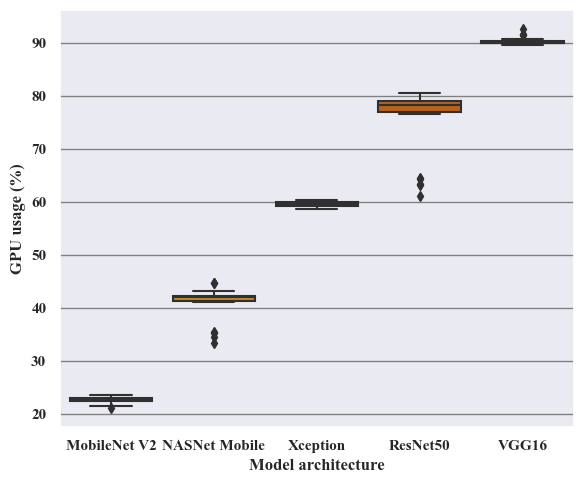

In [15]:
cloud_gpu_data = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet,
        cloud_xception,
        cloud_resnet50,
        cloud_vgg16_no_energy_outliers,
    ]
)
boxplot(
    cloud_gpu_data,
    x="architecture",
    y="gpu_usage",
    xlabel="Model architecture",
    ylabel="GPU usage (%)",
    figname=f"cloud-gpu_usage-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

In [17]:
cloud_nasnet_no_gpu_outliers = cloud_nasnet.sort_values(by="gpu_usage", ascending=True).iloc[3:]
print("Cloud NASNet remaining samples:", cloud_nasnet_no_gpu_outliers.shape[0])
cloud_resnet50_no_gpu_outliers = cloud_resnet50.sort_values(by="gpu_usage", ascending=True).iloc[5:]
print("Cloud ResNet50 remaining samples:", cloud_resnet50_no_gpu_outliers.shape[0])

Cloud NASNet remaining samples: 27
Cloud ResNet50 remaining samples: 25


##### Local ML

In the Local ML environment, we observe that only MobileNet V2 has extreme outliers. We decide to remove them.

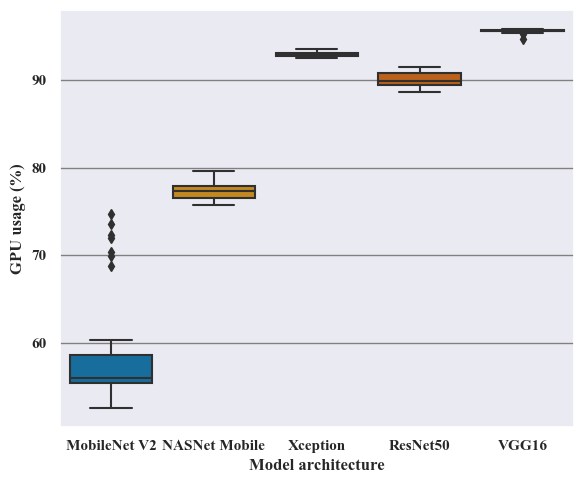

In [18]:
boxplot(
    pd.concat(
        [
            local_ml_mobilenet,
            local_ml_nasnet,
            local_ml_xception,
            local_ml_resnet50,
            local_ml_vgg16,
        ]
    ),
    x="architecture",
    y="gpu_usage",
    xlabel="Model architecture",
    ylabel="GPU usage (%)",
    figname=f"local-v2-gpu_usage-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

In [19]:
local_ml_mobilenet_no_gpu_outliers = local_ml_mobilenet.sort_values(by="gpu_usage", ascending=True).iloc[:-7]
print("Local ML MobileNet remaining samples:", local_ml_mobilenet_no_gpu_outliers.shape[0])

Local ML MobileNet remaining samples: 30


##### Local vs. Cloud

For the Local vs. Cloud analysis of GPU usage, we do not observe any extreme outliers that should be removed.

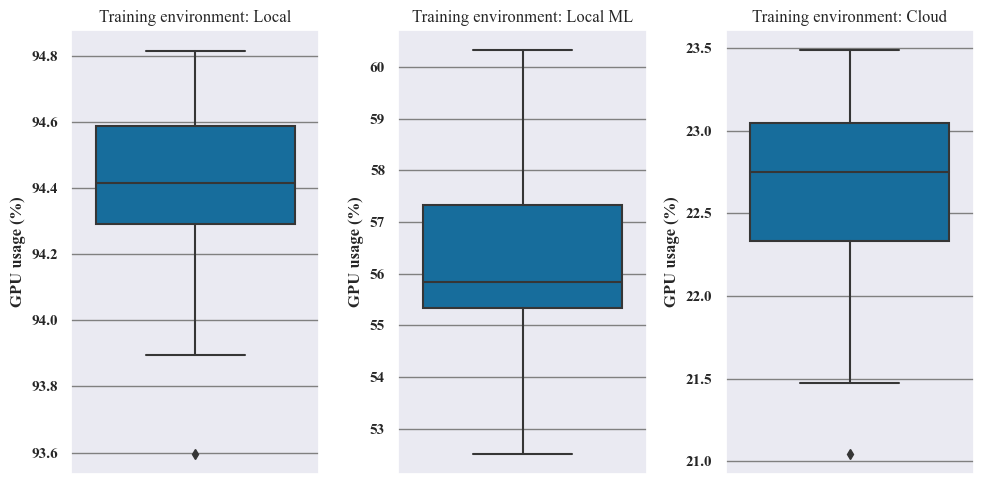

In [20]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 5))
sns.boxplot(y=local_n_mobilenet.gpu_usage, ax=ax1)
ax1.set_ylabel("GPU usage (%)")
ax1.set_title("Training environment: Local")

sns.boxplot(y=local_ml_mobilenet_no_gpu_outliers.gpu_usage, ax=ax2)
ax2.set_ylabel("GPU usage (%)")
ax2.set_title("Training environment: Local ML")

sns.boxplot(y=cloud_mobilenet.gpu_usage, ax=ax3)
ax3.set_ylabel("GPU usage (%)")
ax3.set_title("Training environment: Cloud")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"cloud-local-gpu_usage-boxplot.{FIGURES_FORMAT}"))

#### Temperature
##### Cloud
Now we look for outliers in the temperature of the Cloud architecture. If we look at the boxplots, we observe that the Xception and VGG16 architectures have some outliers. However, these outliers are not extreme and we decide to keep them.

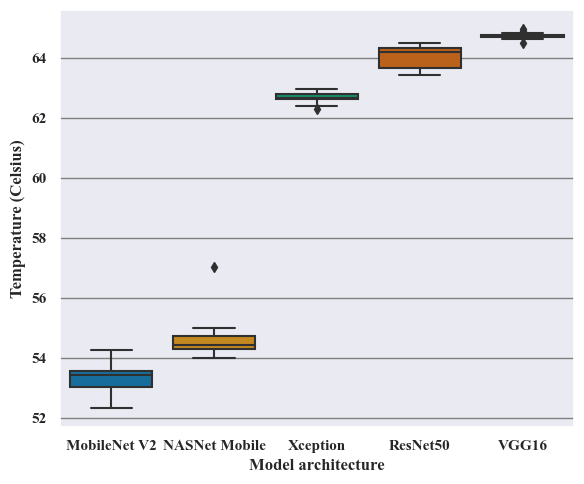

In [21]:
boxplot(
    pd.concat(
        [
            cloud_mobilenet,
            cloud_nasnet_no_gpu_outliers,
            cloud_xception,
            cloud_resnet50_no_gpu_outliers,
            cloud_vgg16_no_energy_outliers,
        ]
    ),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname=f"cloud-temp-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

##### Local N
We check the outliers for the Local "Normal User" environment. In this case, we do not observe any outliers in the data.

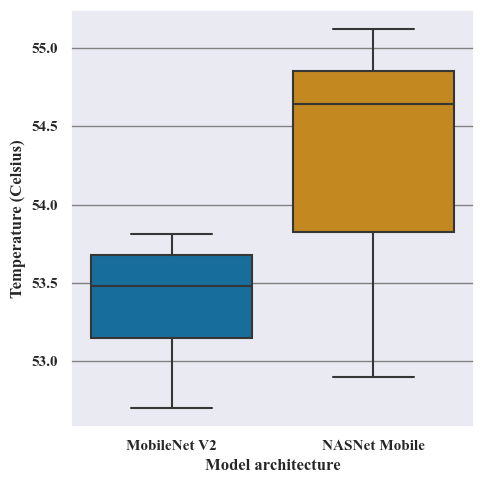

In [22]:
boxplot(
    pd.concat([local_n_mobilenet, local_n_nasnet]),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname=f"local-temp-boxplot.{FIGURES_FORMAT}",
)

##### Local ML
In the Local ML environment, we observe that MobileNet V2, Xception, and ResNet50 have outliers. However, we decide to keep them given the small difference in temperature of the outliers with the remaining samples of each group.

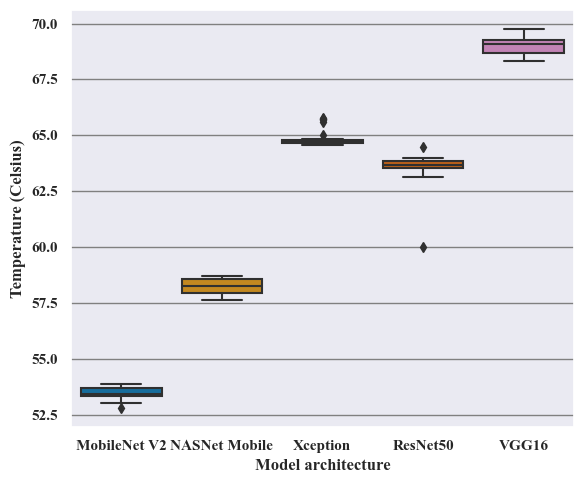

In [23]:
boxplot(
    pd.concat(
        [
            local_ml_mobilenet_no_gpu_outliers,
            local_ml_nasnet,
            local_ml_xception,
            local_ml_resnet50,
            local_ml_vgg16,
        ]
    ),
    x="architecture",
    y="temperature",
    xlabel="Model architecture",
    ylabel="Temperature (Celsius)",
    figname=f"local-v2-temp-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

#### $F_1$ score
Given that the variation in $F_1$ score is a natural outcome of the training process, we only remove those samples that have a $F_1$ score of 0. This is because a $F_1$ score of 0 indicates that the model is not able to predict any of the classes, which is a extraneous behavior.

In [24]:
mobilenet = pd.concat([local_n_mobilenet, local_ml_mobilenet_no_gpu_outliers, cloud_mobilenet])
nasnet = pd.concat([local_n_nasnet, local_ml_nasnet, cloud_nasnet_no_gpu_outliers])
xception = pd.concat([local_ml_xception, cloud_xception])
resnet50 = pd.concat([local_ml_resnet50, cloud_resnet50_no_gpu_outliers])
vgg16 = pd.concat([local_ml_vgg16, cloud_vgg16_no_energy_outliers])
f1_df = pd.concat([mobilenet, nasnet, xception, resnet50, vgg16]).query("`f1-score` > 0")

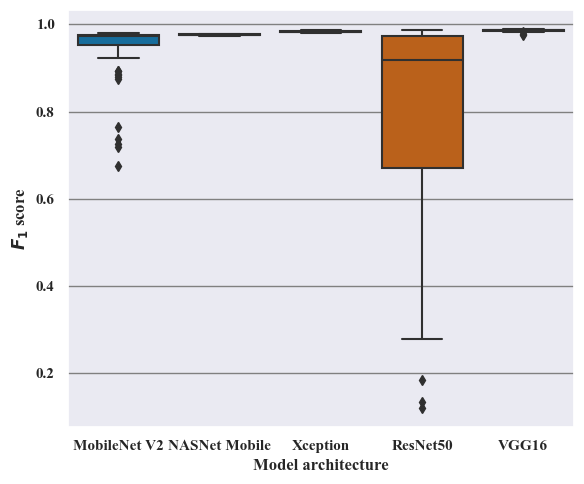

In [25]:
boxplot(
    f1_df,
    x="architecture",
    y="f1-score",
    xlabel="Model architecture",
    ylabel="$F_1$ score",
    figname=f"f1score-boxplot.{FIGURES_FORMAT}",
    figsize=(6, 5),
)

### Impact of temperature on energy consumption

In [26]:
temp_vs_energy_df = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet_no_gpu_outliers,
        cloud_xception,
        cloud_resnet50_no_gpu_outliers,
        cloud_vgg16_no_energy_outliers,
        local_n_mobilenet,
        local_n_nasnet,
        local_ml_mobilenet_no_gpu_outliers,
        local_ml_nasnet,
        local_ml_xception,
        local_ml_resnet50,
        local_ml_vgg16,
    ]
)

Looking at the scatter plot of the temperature vs. energy, we do not observe any clear correlation between the two variables in a general view. However, this might not be the case when we look at the data for each environment separately.

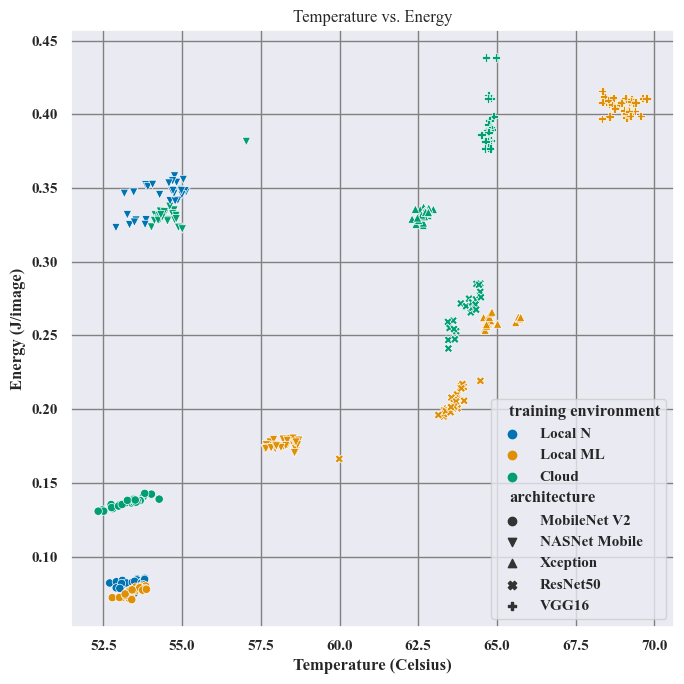

In [27]:
_, axes = plt.subplots(1, 1, figsize=((7, 7)))
ax = sns.scatterplot(
    temp_vs_energy_df,
    x="temperature",
    y="energy",
    ax=axes,
    style="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    markers=MARKERS,
)
ax.set_title("Temperature vs. Energy")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("Energy (J/image)")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"temperature-energy-scatter.{FIGURES_FORMAT}"))

plt.show()

#### Test normality assumption
Before performing any statistical analysis, we need to check if the data is normally distributed. We do this by observing the Q-Q plot of the data and by performing the Shapiro-Wilk test.

Shapiro test for normality of group 0: W = 0.761440098285675 and p-value 7.311179792005365e-14
Shapiro test for normality of group 1: W = 0.8454191088676453 and p-value 7.273236179994313e-11
Levene test for equal variances: W = 167.38100316774742 and p-value = 2.489937737592651e-30


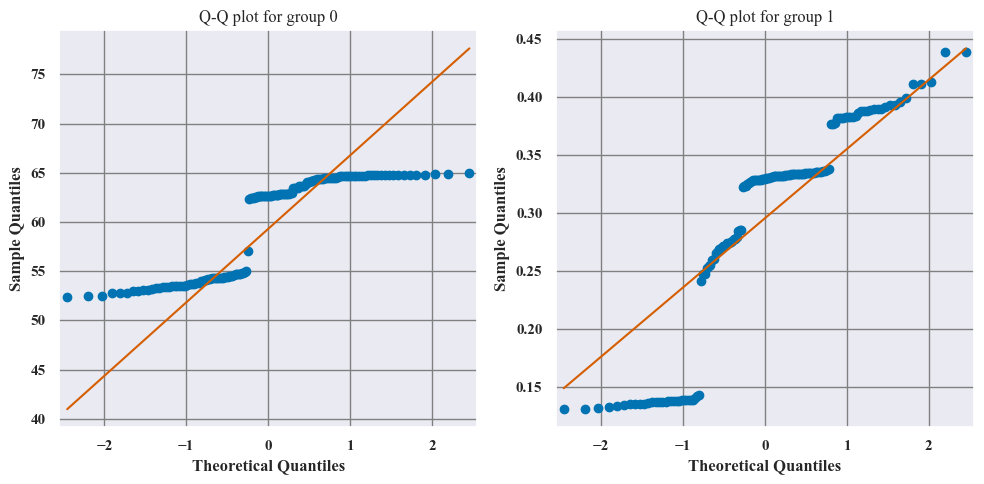

In [28]:
cloud_df = temp_vs_energy_df.query("`training environment` == 'Cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["energy"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.9090379476547241 and p-value 0.00028551919967867434
Shapiro test for normality of group 1: W = 0.6773823499679565 and p-value 3.3316335801281127e-10
Levene test for equal variances: W = 56.86952155387341 and p-value = 1.0536267785654708e-11


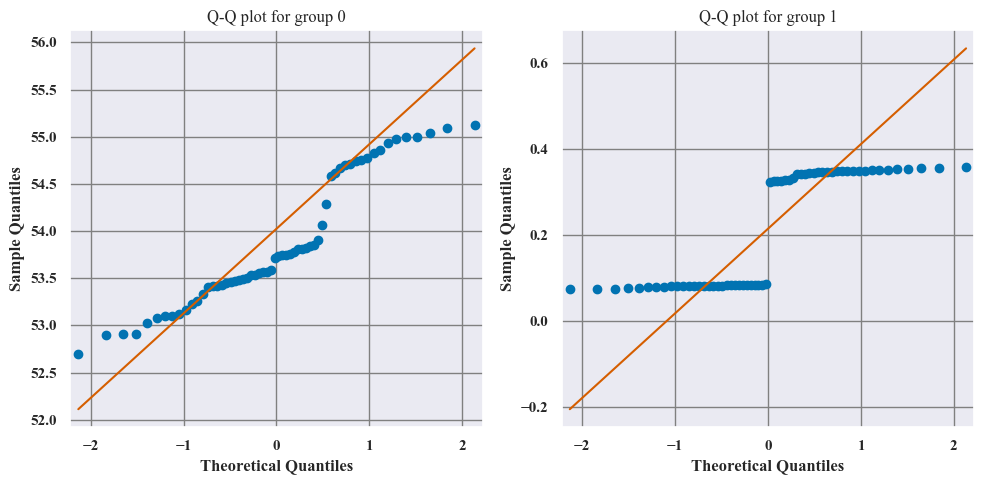

In [29]:
local_n_df = temp_vs_energy_df.query("`training environment` == 'Local N'")
test_assumptions(local_n_df["temperature"], local_n_df["energy"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.8964983820915222 and p-value 7.090301679113509e-09
Shapiro test for normality of group 1: W = 0.8860326409339905 and p-value 1.9342696333524145e-09
Levene test for equal variances: W = 235.88037160708558 and p-value = 9.688843714024664e-40


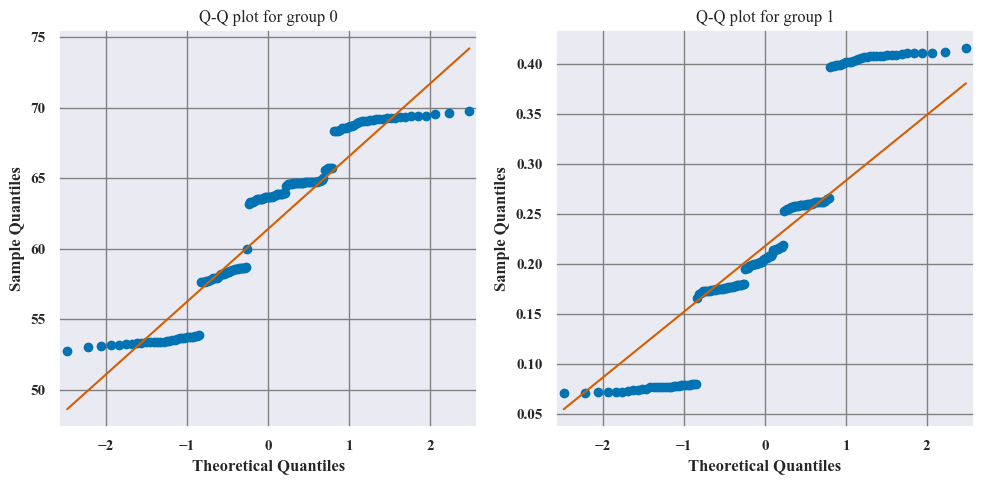

In [30]:
local_ml_df = temp_vs_energy_df.query("`training environment` == 'Local ML'")
test_assumptions(local_ml_df["temperature"], local_ml_df["energy"], nrows=1, ncols=2, figsize=(10, 5))

The visual assessment and the Shapiro-Wilk test indicate that the data is not normally distributed. Therefore, we perform the Spearman's rank correlation test.

#### Spearman's rank correlation test
The results of the correlation test show that there is a positive correlation between temperature and energy consumption. However, we observe different behaviors depending on the environment.

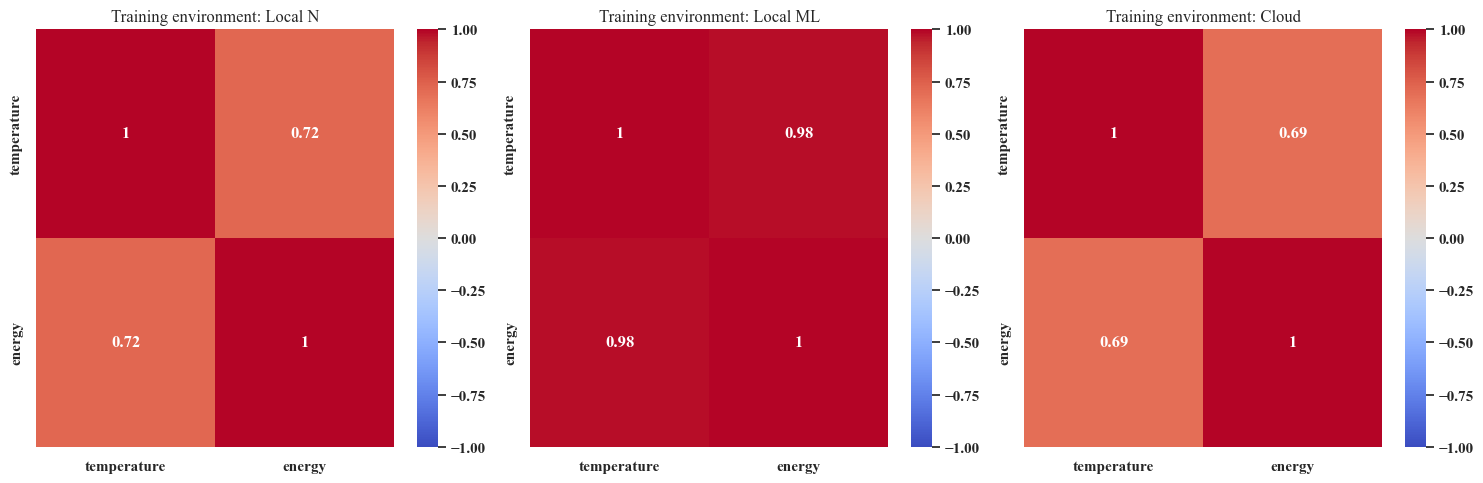

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, strategy in enumerate(TRAIN_STRATEGIES):
    data = temp_vs_energy_df.query("`training environment` == @strategy")[["temperature", "energy"]]

    corr = data.corr("spearman")
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[i], cmap="coolwarm")
    ax.set_title(f"Training environment: {strategy}")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"temperature-energy-correlation.{FIGURES_FORMAT}"))

### Impact of temperature on GPU usage

As with the energy consumption, we do not observe a particular correlation between temperature and GPU usage in a general view. However, when looking at the data for each environment separately, we there seems to be a positive correlation between temperature and GPU usage.

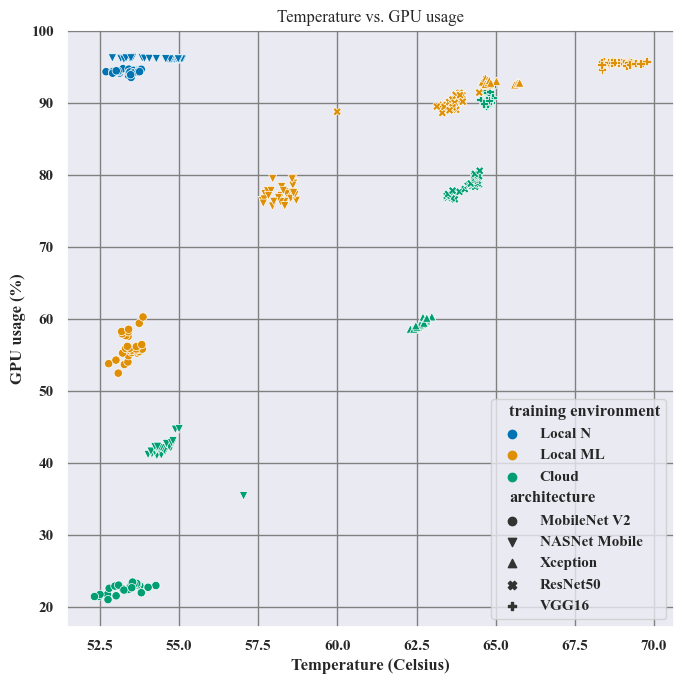

In [32]:
_, axes = plt.subplots(1, 1, figsize=((7, 7)))
ax = sns.scatterplot(
    temp_vs_energy_df,
    x="temperature",
    y="gpu_usage",
    ax=axes,
    style="architecture",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    markers=MARKERS,
)
ax.set_title("Temperature vs. GPU usage")
ax.set_xlabel("Temperature (Celsius)")
ax.set_ylabel("GPU usage (%)")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"temperature-gpu_usage-scatter.{FIGURES_FORMAT}"))

plt.show()

#### Test normality assumption
As in the previous correlation analysis, we check the normality of the data.

Shapiro test for normality of group 0: W = 0.761440098285675 and p-value 7.311179792005365e-14
Shapiro test for normality of group 1: W = 0.8903614282608032 and p-value 8.814802221479567e-09
Levene test for equal variances: W = 216.15503359129323 and p-value = 1.1806325399196644e-36


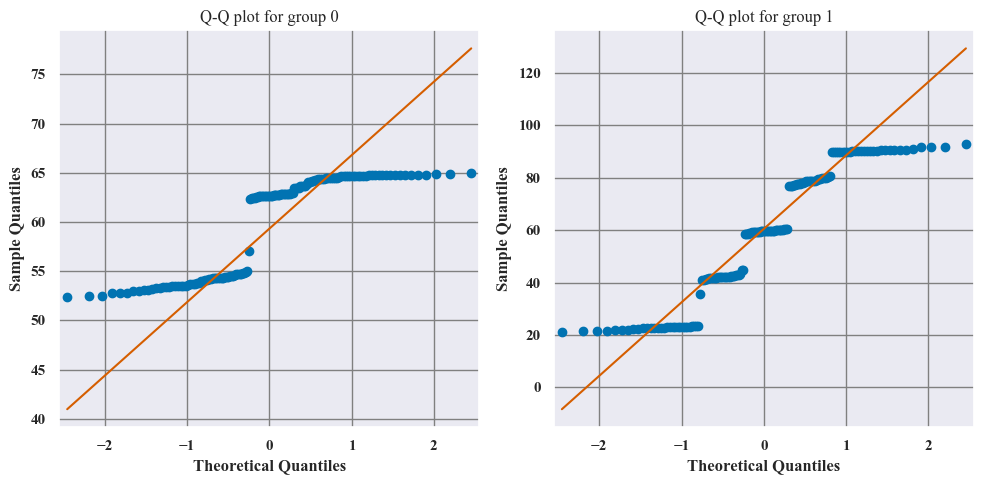

In [33]:
cloud_df = temp_vs_energy_df.query("`training environment` == 'Cloud'")
test_assumptions(cloud_df["temperature"], cloud_df["gpu_usage"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.9090379476547241 and p-value 0.00028551919967867434
Shapiro test for normality of group 1: W = 0.7974491715431213 and p-value 1.1669445143525081e-07
Levene test for equal variances: W = 28.660322247087283 and p-value = 4.3089620006896495e-07


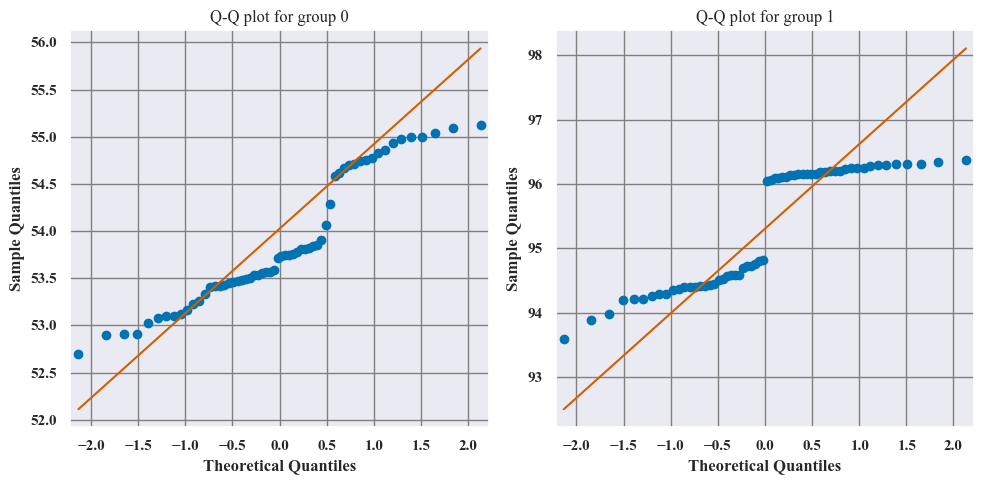

In [34]:
local_n_df = temp_vs_energy_df.query("`training environment` == 'Local N'")
test_assumptions(local_n_df["temperature"], local_n_df["gpu_usage"], nrows=1, ncols=2, figsize=(10, 5))

Shapiro test for normality of group 0: W = 0.9090379476547241 and p-value 0.00028551919967867434
Shapiro test for normality of group 1: W = 0.7974491715431213 and p-value 1.1669445143525081e-07
Levene test for equal variances: W = 28.660322247087283 and p-value = 4.3089620006896495e-07


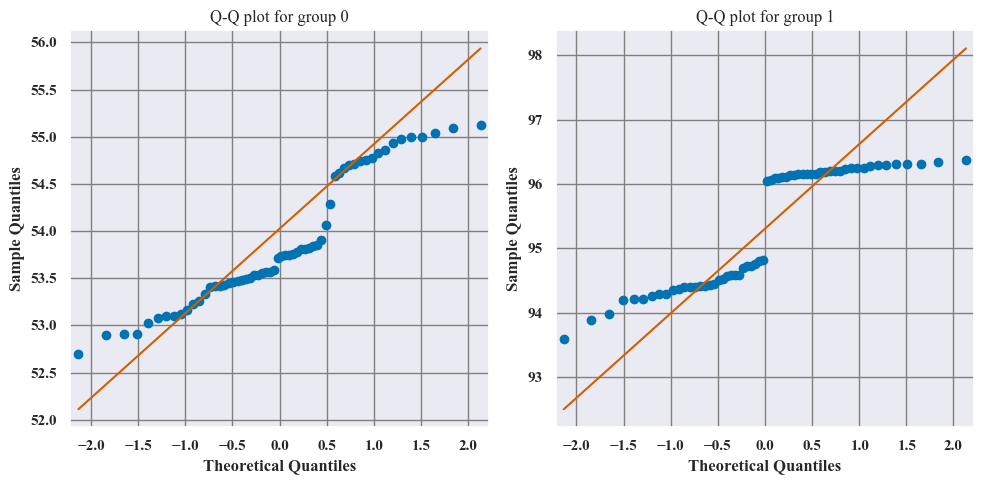

In [35]:
local_ml_df = temp_vs_energy_df.query("`training environment` == 'Local ML'")
test_assumptions(local_n_df["temperature"], local_n_df["gpu_usage"], nrows=1, ncols=2, figsize=(10, 5))

The visual assessment and the Shapiro-Wilk test indicate that the data is not normally distributed. Therefore, we perform the Spearman's rank correlation test.

#### Spearman's rank correlation test
The results of the correlation test show that there is a positive correlation between temperature and energy consumption. Moreover, we find a very strong correlation between temperature and GPU usage in the Local ML and Cloud environments.

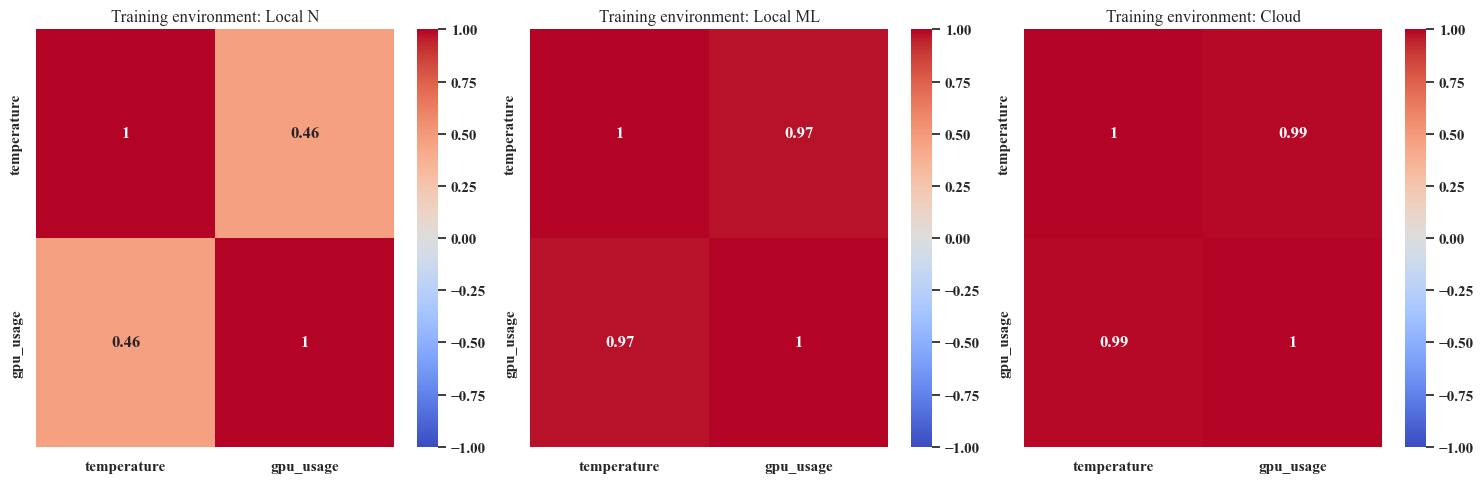

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, strategy in enumerate(TRAIN_STRATEGIES):
    data = temp_vs_energy_df.query("`training environment` == @strategy")[["temperature", "gpu_usage"]]
    corr = data.corr("spearman")
    # print(strategy)
    # print(corr, end="\n\n")
    ax = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, ax=axes[i], cmap="coolwarm")
    ax.set_title(f"Training environment: {strategy}")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"temperature-gpu_usage-correlation.{FIGURES_FORMAT}"))

### Comparison between model architectures and training environment
#### Energy comparison

In [37]:
analysis_df_no_outliers = (
    pd.concat(
        [
            cloud_mobilenet,
            cloud_nasnet_no_gpu_outliers,
            cloud_xception,
            cloud_resnet50_no_gpu_outliers,
            cloud_vgg16_no_energy_outliers,
            local_n_mobilenet,
            local_n_nasnet,
            local_ml_mobilenet_no_gpu_outliers,
            local_ml_nasnet,
            local_ml_xception,
            local_ml_resnet50,
            local_ml_vgg16,
        ]
    )
    .query("`f1-score` > 0")
    .sort_values(by=["GFLOPs", "training environment", "architecture"], ascending=True)
    .reset_index(drop=True)
)

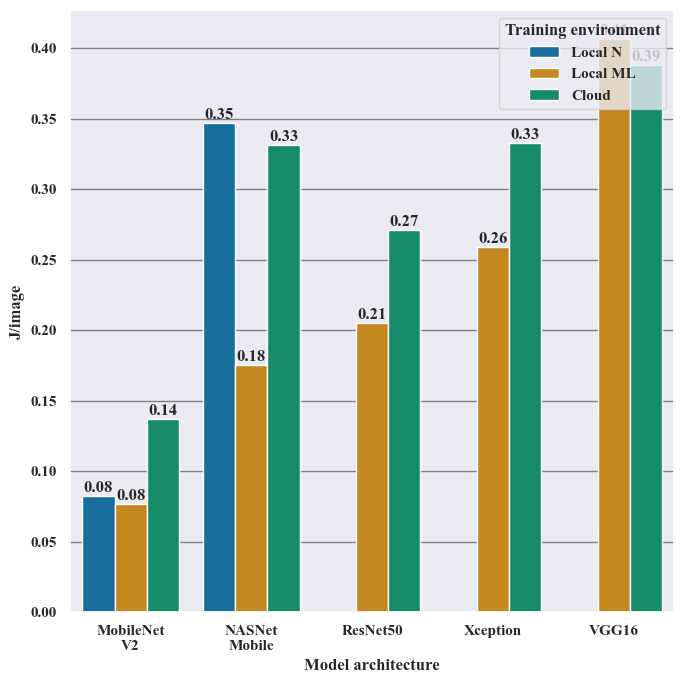

In [38]:
_, ax1 = plt.subplots(1, 1, figsize=((7, 7)))
_, ax = barplot(
    analysis_df_no_outliers,
    x="architecture",
    y="energy",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    xlabel="Model architecture",
    ylabel="J/image",
    barlabel=True,
    ax=ax1,
)
ax.legend(title="Training environment", loc="upper right")
labels = [label.get_text().replace(" ", "\n") for label in ax1.get_xticklabels()]
ax1.set_xticklabels(labels)

plt.savefig(os.path.join(FIGURES_DIR, f"energy-comparison-full.{FIGURES_FORMAT}"))

##### Energy improvement within architectures

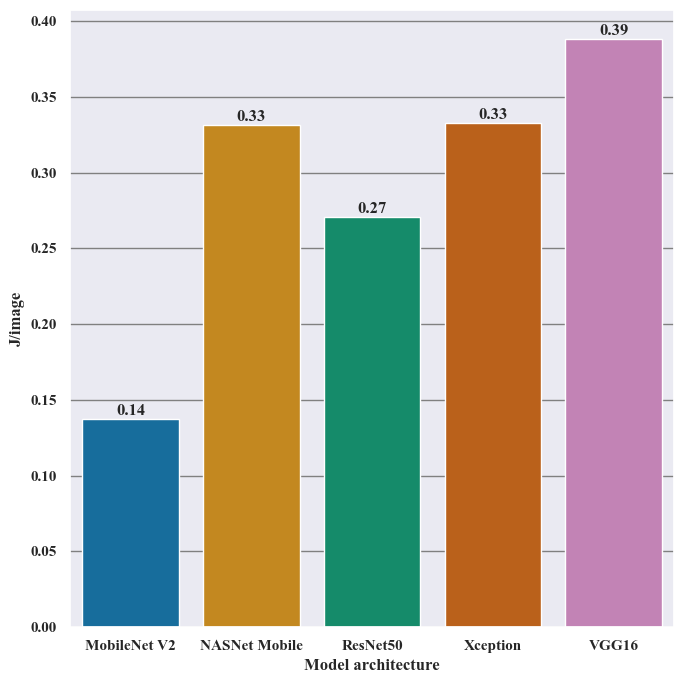

In [39]:
_, ax1 = plt.subplots(1, 1, figsize=((7, 7)))
_, ax = barplot(
    analysis_df_no_outliers.query("`training environment` == 'Cloud'"),
    x="architecture",
    y="energy",
    estimator="median",
    xlabel="Model architecture",
    ylabel="J/image",
    barlabel=True,
    ax=ax1,
)

plt.savefig(os.path.join(FIGURES_DIR, f"energy-comparison-cloud.{FIGURES_FORMAT}"))

In [40]:
improvement = (
    cloud_vgg16_no_energy_outliers.energy.median() - cloud_mobilenet.energy.median()
) / cloud_vgg16_no_energy_outliers.energy.median()
print(f"Maximum improvement: {improvement}")

Maximum improvement: 0.6464492766996094


In [41]:
improvement = (
    cloud_vgg16_no_energy_outliers.energy.median() - cloud_xception.energy.median()
) / cloud_vgg16_no_energy_outliers.energy.median()
print(f"Minimum improvement: {improvement}")

Minimum improvement: 0.14199170001745376


##### Energy improvement within training strategies

In [42]:
improvement = (
    cloud_mobilenet.energy.median() - local_ml_mobilenet_no_gpu_outliers.energy.median()
) / cloud_mobilenet.energy.median()
print(f"Maximum improvement: {improvement}")

Maximum improvement: 0.4377243371752625


In [43]:
improvement = (cloud_mobilenet.energy.median() - local_n_mobilenet.energy.median()) / cloud_mobilenet.energy.median()
print(f"Minimum improvement: {improvement}")

Minimum improvement: 0.4009087826351266


##### Overall energy improvement

In [44]:
print_improvement(analysis_df_no_outliers, "energy")

Maximum improvement: 0.8104490281478606 (VGG16 - Local ML, MobileNet V2 - Local ML)
Minimum improvement: 0.004222699533913209 (Xception - Cloud, NASNet Mobile - Cloud)


#### GPU usage comparison

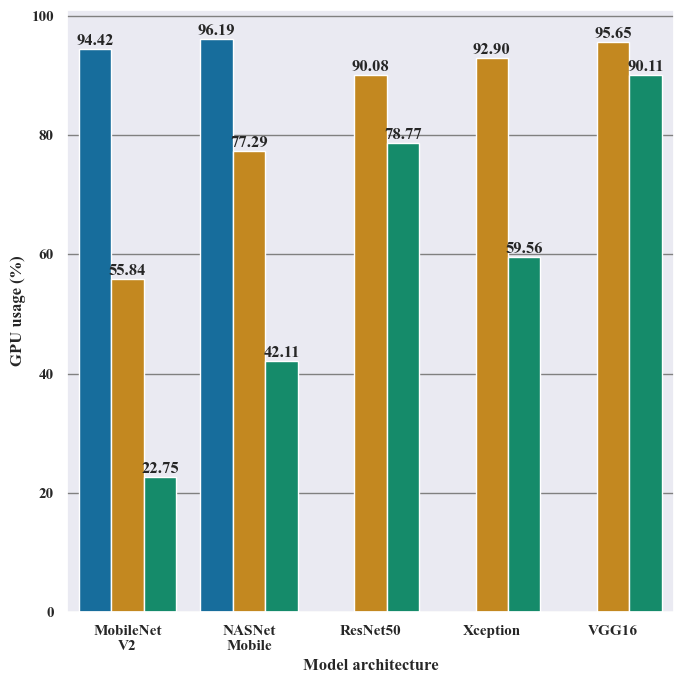

In [45]:
_, ax1 = plt.subplots(1, 1, figsize=((7, 7)))
_, ax = barplot(
    analysis_df_no_outliers,
    x="architecture",
    y="gpu_usage",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    xlabel="Model architecture",
    ylabel="GPU usage (%)",
    barlabel=True,
    ax=ax1,
)

labels = [label.get_text().replace(" ", "\n") for label in ax1.get_xticklabels()]
ax1.set_xticklabels(labels)

ax.get_legend().remove()
plt.savefig(os.path.join(FIGURES_DIR, f"gpu-comparison-full.{FIGURES_FORMAT}"))

#### GPU usage comparison within architectures

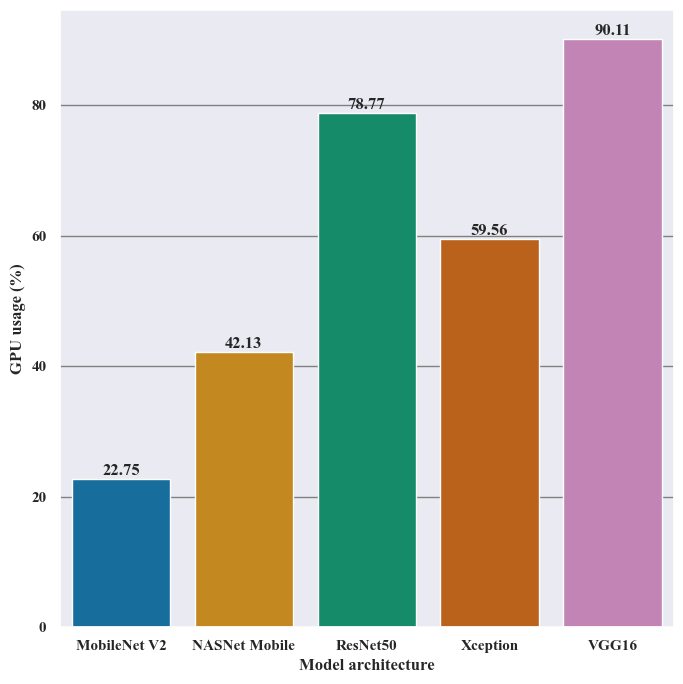

In [ ]:
_, ax1 = plt.subplots(1, 1, figsize=((7, 7)))
_, ax = barplot(
    analysis_df_no_outliers.query("`training environment` == 'Cloud'"),
    x="architecture",
    y="gpu_usage",
    estimator="median",
    xlabel="Model architecture",
    ylabel="GPU usage (%)",
    barlabel=True,
    ax=ax1,
)

plt.savefig(os.path.join(FIGURES_DIR, f"gpu-comparison-cloud.{FIGURES_FORMAT}"))

#### Training time comparison

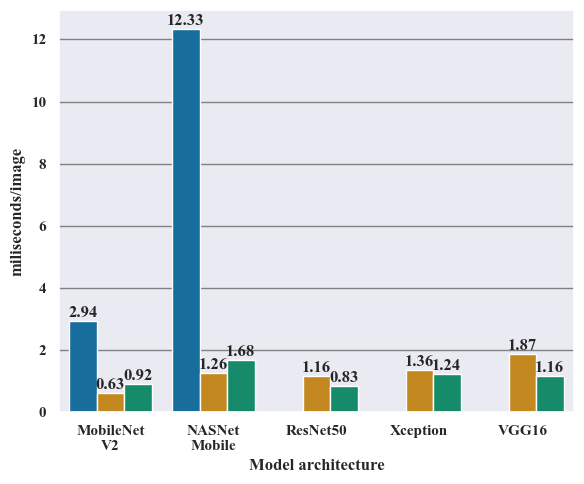

In [46]:
_, ax = barplot(
    analysis_df_no_outliers,
    x="architecture",
    y="normalized duration",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    estimator="median",
    xlabel="Model architecture",
    ylabel="miliseconds/image",
    barlabel=True,
    figsize=(6, 5),
)

labels = [label.get_text().replace(" ", "\n") for label in ax.get_xticklabels()]
ax.set_xticklabels(labels)

ax.get_legend().remove()

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"training-time-comparison-full.{FIGURES_FORMAT}"))

#### Training time comparison within architectures

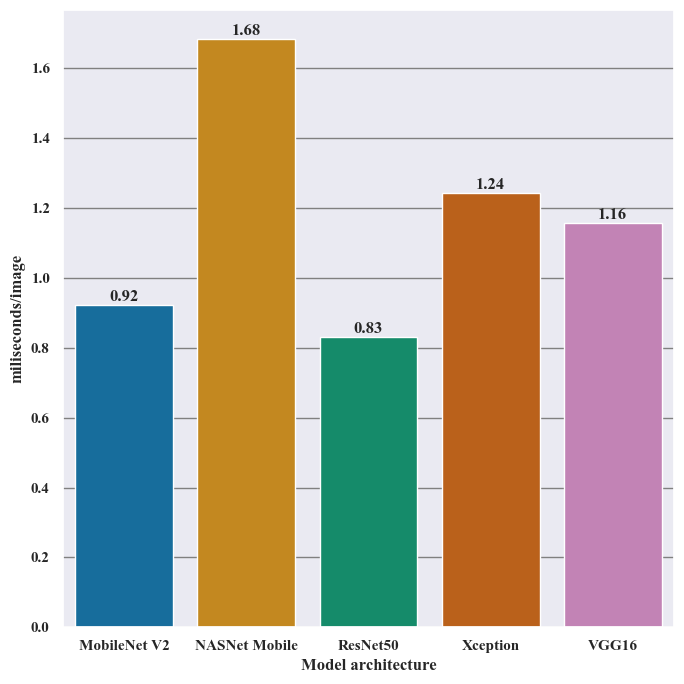

In [ ]:
_, ax = barplot(
    analysis_df_no_outliers.query("`training environment` == 'Cloud'"),
    x="architecture",
    y="normalized duration",
    estimator="median",
    xlabel="Model architecture",
    ylabel="miliseconds/image",
    barlabel=True,
    figsize=(7, 7),
)

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"training-time-comparison-cloud.{FIGURES_FORMAT}"))

#### $F_1$ score comparison

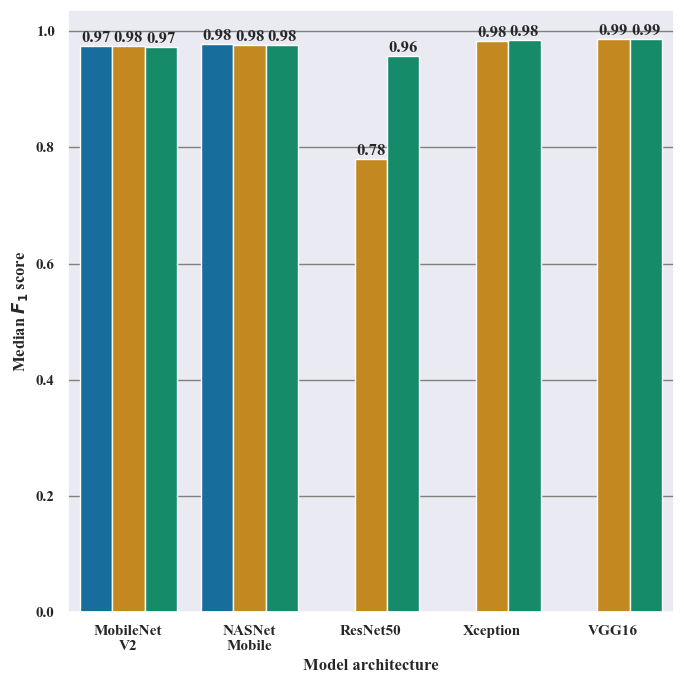

In [ ]:
_, ax = barplot(
    analysis_df_no_outliers,
    x="architecture",
    y="f1-score",
    xlabel="Model architecture",
    ylabel="Median $F_1$ score",
    estimator="median",
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    barlabel=True,
    figsize=(7, 7),
)

ax.get_legend().remove()
labels = [label.get_text().replace(" ", "\n") for label in ax.get_xticklabels()]
ax.set_xticklabels(labels)

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"accuracy-comparison.{FIGURES_FORMAT}"))

##### $F_1$ score improvement within architectures

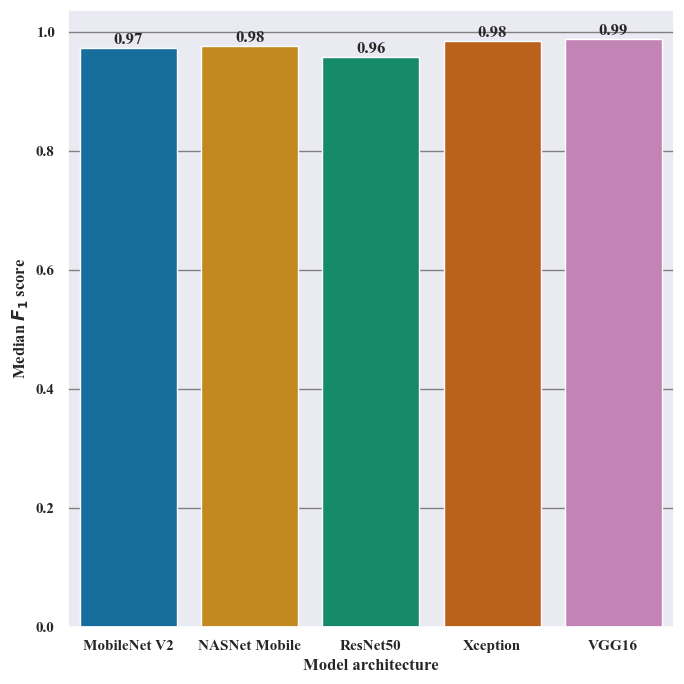

In [ ]:
_, ax = barplot(
    analysis_df_no_outliers.query("`training environment` == 'Cloud'"),
    x="architecture",
    y="f1-score",
    xlabel="Model architecture",
    ylabel="Median $F_1$ score",
    estimator="median",
    barlabel=True,
    figname=f"cloud-f1score-comparison.{FIGURES_FORMAT}",
    figsize=(7, 7),
)

In [ ]:
improvement = (
    cloud_vgg16_no_energy_outliers["f1-score"].median() - cloud_resnet50_no_gpu_outliers["f1-score"].median()
) / cloud_vgg16_no_energy_outliers["f1-score"].median()
print(f"Maximum improvement: {improvement}")
1 - improvement

Maximum improvement: 0.030557545836576758


0.9694424541634232

In [ ]:
improvement = (
    cloud_vgg16_no_energy_outliers["f1-score"].median() - cloud_xception["f1-score"].median()
) / cloud_vgg16_no_energy_outliers["f1-score"].median()
print(f"Minimum improvement: {improvement}")
1 - improvement

Minimum improvement: 0.0025926907201687037


0.9974073092798313

##### Overall $F_1$ score improvement

In [ ]:
print_improvement(analysis_df_no_outliers, "f1-score")

Maximum improvement: 0.20913895287181744 (VGG16 - Cloud, ResNet50 - Local ML)
Minimum improvement: 0.00035691008086339204 (NASNet Mobile - Local ML, MobileNet V2 - Local ML)


### Trade-off between accuracy and energy

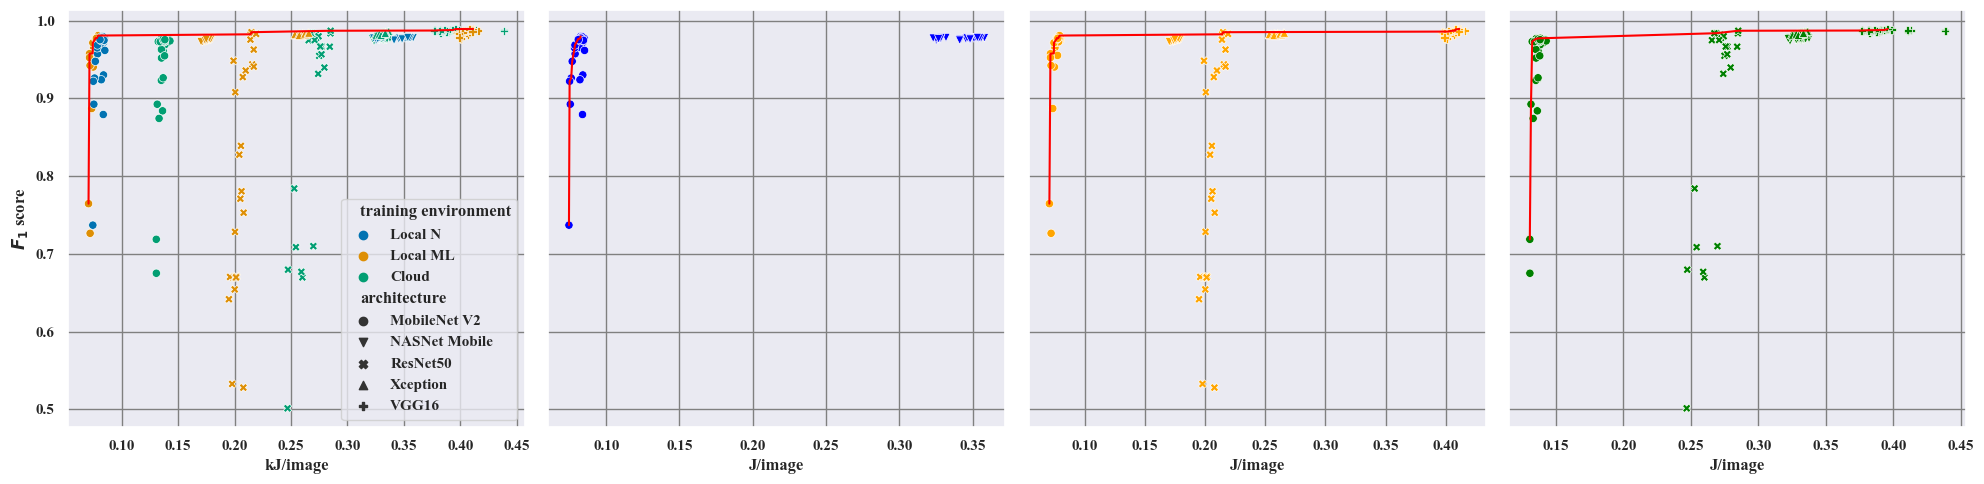

In [ ]:
_, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

colors = {"Cloud": "green", "Local N": "blue", "Local ML": "orange"}

tradeoff_data = analysis_df_no_outliers.query("`f1-score` >= 0.5")
costs = tradeoff_data[["energy", "f1-score"]].to_numpy()
pareto = is_pareto_efficient(costs)
sns.scatterplot(
    tradeoff_data,
    x="energy",
    y="f1-score",
    style="architecture",
    markers=MARKERS,
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    ax=axes[0],
)
sns.lineplot(tradeoff_data.loc[pareto], x="energy", y="f1-score", ax=axes[0], color="red")
axes[0].grid(visible=True, axis="both")

axes[0].set_xlabel("kJ/image")
axes[0].set_ylabel("$F_1$ score")

for i, strategy in enumerate(TRAIN_STRATEGIES, 1):
    data = tradeoff_data.query("`training environment` == @strategy")
    costs = data[["energy", "f1-score"]].to_numpy()
    pareto = is_pareto_efficient(costs)
    sns.scatterplot(
        data,
        x="energy",
        y="f1-score",
        style="architecture",
        markers=MARKERS,
        color=colors[strategy],
        ax=axes[i],
    )
    sns.lineplot(data.loc[pareto], x="energy", y="f1-score", ax=axes[i], color="red")

    axes[i].get_legend().remove()
    axes[i].set_xlabel("J/image")

    axes[i].grid(visible=True, axis="both")


if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"accuracy-energy-comparison.{FIGURES_FORMAT}"))

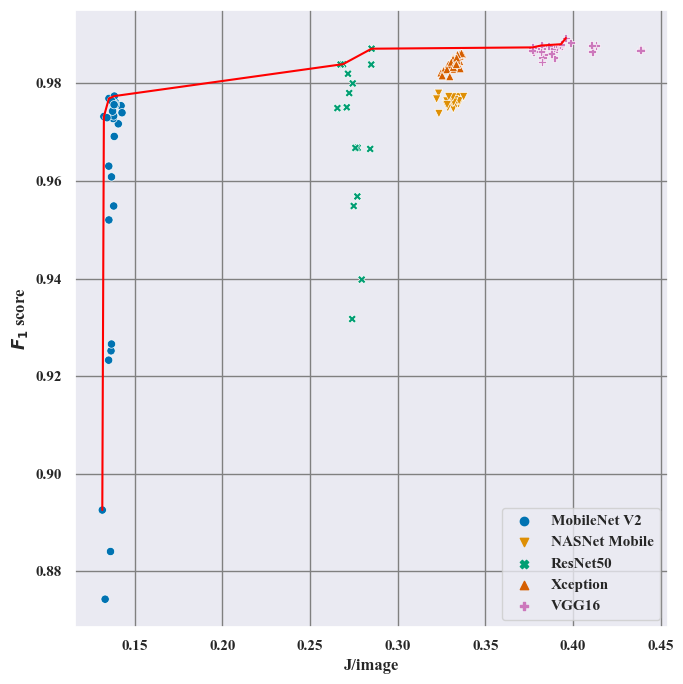

In [ ]:
_, ax = plt.subplots(1, 1, figsize=(7, 7))

colors = {"Cloud": "green", "Local N": "blue", "Local ML": "orange"}

tradeoff_data = analysis_df_no_outliers.query("`training environment` == 'Cloud' & `f1-score` >= 0.8")
costs = tradeoff_data[["energy", "f1-score"]].to_numpy()
pareto = is_pareto_efficient(costs)
sns.scatterplot(
    tradeoff_data,
    x="energy",
    y="f1-score",
    style="architecture",
    markers=MARKERS,
    hue="architecture",
    ax=ax,
)
ax.grid(visible=True, axis="both")

ax.set_xlabel("J/image")
ax.set_ylabel("$F_1$ score")

sns.lineplot(tradeoff_data.loc[pareto], x="energy", y="f1-score", ax=ax, color="red")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"accuracy-energy-cloud-comparison.{FIGURES_FORMAT}"))

#### Correlation between $F_1$ score and energy
Looking at the Spearman $\rho$ correlation coefficient, we observe that there is a strong positive correlation between $F_1$ score and energy consumption.

In [ ]:
results_df = pd.DataFrame(columns=["training environment", "rho", "p-value"])

for strategy in TRAIN_STRATEGIES:
    data = analysis_df_no_outliers.query("`training environment` == @strategy")
    if not data.empty:
        # print(strategy, architecture)
        corr = stats.spearmanr(data.energy, data["f1-score"], alternative="greater")
        # print(corr)
        # print()
        results_df.loc[len(results_df)] = [strategy, corr[0], corr[1]]
results_df

,training environment,rho,p-value
0,Local N,0.655515,6.585477e-09
1,Local ML,0.731627,7.123300e-27
2,Cloud,0.841879,4.334149e-39


### Energy vs. GPU usage

In [ ]:
cloud_energy_vs_gpu_usage_df = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet_no_gpu_outliers,
        cloud_xception,
        cloud_resnet50_no_gpu_outliers,
        cloud_vgg16_no_energy_outliers,
    ]
)
local_n_energy_vs_gpu_usage_df = pd.concat(
    [
        local_n_mobilenet,
        local_n_nasnet,
    ]
)

local_ml_energy_vs_gpu_usage_df = pd.concat(
    [
        local_ml_mobilenet_no_gpu_outliers,
        local_ml_nasnet,
        local_ml_xception,
        local_ml_resnet50,
        local_ml_vgg16,
    ]
)

From a general perspective, we do not observe a clear correlation between energy consumption and GPU usage.

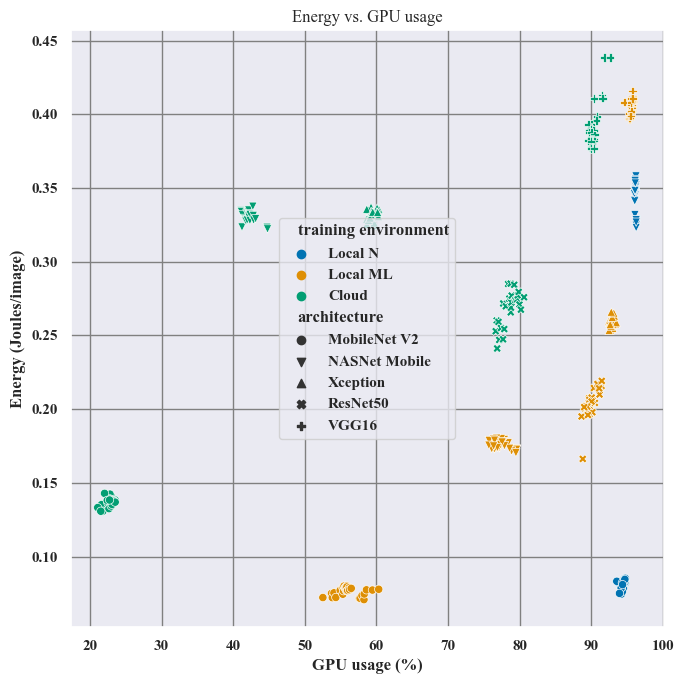

In [ ]:
energy_vs_gpu_usage_df = pd.concat(
    [local_n_energy_vs_gpu_usage_df, local_ml_energy_vs_gpu_usage_df, cloud_energy_vs_gpu_usage_df]
)

_, axis = plt.subplots(1, 1, figsize=((7, 7)))
ax = sns.scatterplot(
    energy_vs_gpu_usage_df,
    y="energy",
    x="gpu_usage",
    ax=axis,
    hue="training environment",
    hue_order=TRAIN_STRATEGIES,
    style="architecture",
    markers=MARKERS,
    legend="brief",
)
ax.set_title("Energy vs. GPU usage")
ax.set_ylabel("Energy (Joules/image)")
ax.set_xlabel("GPU usage (%)")
plt.show()

#### Correlation between energy and GPU usage

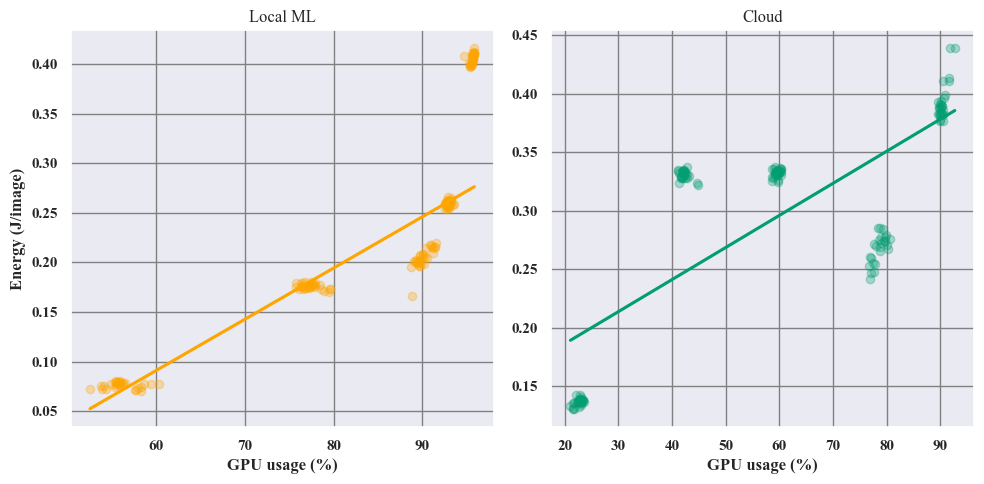

In [ ]:
_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))
tmp = local_ml_energy_vs_gpu_usage_df.copy()
tmp.energy = local_ml_energy_vs_gpu_usage_df.energy.apply(np.log)
ax = sns.regplot(
    local_ml_energy_vs_gpu_usage_df,
    y="energy",
    x="gpu_usage",
    ax=ax0,
    color=COLORS["Local ML"],
    ci=None,
    robust=True,
    scatter_kws={"alpha": 0.3},
)
ax.set_title("Local ML")
ax.set_ylabel("Energy (J/image)")
ax.set_xlabel("GPU usage (%)")

tmp = cloud_energy_vs_gpu_usage_df.copy()
tmp.energy = cloud_energy_vs_gpu_usage_df.energy.apply(np.log)
ax = sns.regplot(
    cloud_energy_vs_gpu_usage_df,
    y="energy",
    x="gpu_usage",
    ax=ax1,
    color=COLORS["Cloud"],
    ci=None,
    robust=True,
    scatter_kws={"alpha": 0.3},
)
ax.set_title("Cloud")
ax.set_ylabel(None)
ax.set_xlabel("GPU usage (%)")

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"energy-gpu-regression.{FIGURES_FORMAT}"))

In [ ]:
stats.spearmanr(
    local_ml_energy_vs_gpu_usage_df.energy,
    local_ml_energy_vs_gpu_usage_df.gpu_usage,
    alternative="greater",
)

SignificanceResult(statistic=0.9716202270381836, pvalue=4.091556154464209e-96)

In [ ]:
stats.spearmanr(
    cloud_energy_vs_gpu_usage_df.energy,
    cloud_energy_vs_gpu_usage_df.gpu_usage,
    alternative="greater",
)

SignificanceResult(statistic=0.6897902954232359, pvalue=2.1517813204356922e-21)

## Statistical significance analysis

### RQ1 - What is the impact of model architecture on a computer vision system with respect to energy efficiency and model correctness?

In [ ]:
rq1_df = pd.concat(
    [
        cloud_mobilenet,
        cloud_nasnet_no_gpu_outliers,
        cloud_xception,
        cloud_resnet50_no_gpu_outliers.query("`f1-score` > 0"),
        cloud_vgg16_no_energy_outliers,
    ]
)
rq1_df.energy = rq1_df.energy.apply(np.sqrt)

#### RQ1.1 - How do DL architectures compare in terms of energy efficiency?

##### Energy
First we test the assumption of normality and homogeneity of the data. After applying a square root transformation to the energy data, we observe that the data is normally distributed. However, the data is not homogenous. Although the Shapiro-Wilk test indicates that the VGG16 data is not normally distributed, seeing the Q-Q plot we consider that the assumption of normality is met. Therefore, we perform a Welch's ANOVA test.

Shapiro test for normality of group 0: W = 0.9548591375350952 and p-value 0.22768506407737732
Shapiro test for normality of group 1: W = 0.9513898491859436 and p-value 0.249888077378273
Shapiro test for normality of group 2: W = 0.9390495419502258 and p-value 0.08575432747602463
Shapiro test for normality of group 3: W = 0.9370869398117065 and p-value 0.12676182389259338
Shapiro test for normality of group 4: W = 0.7748271822929382 and p-value 3.050559462280944e-05
Levene test for equal variances: W = 8.686104705667502 and p-value = 2.864666711837625e-06


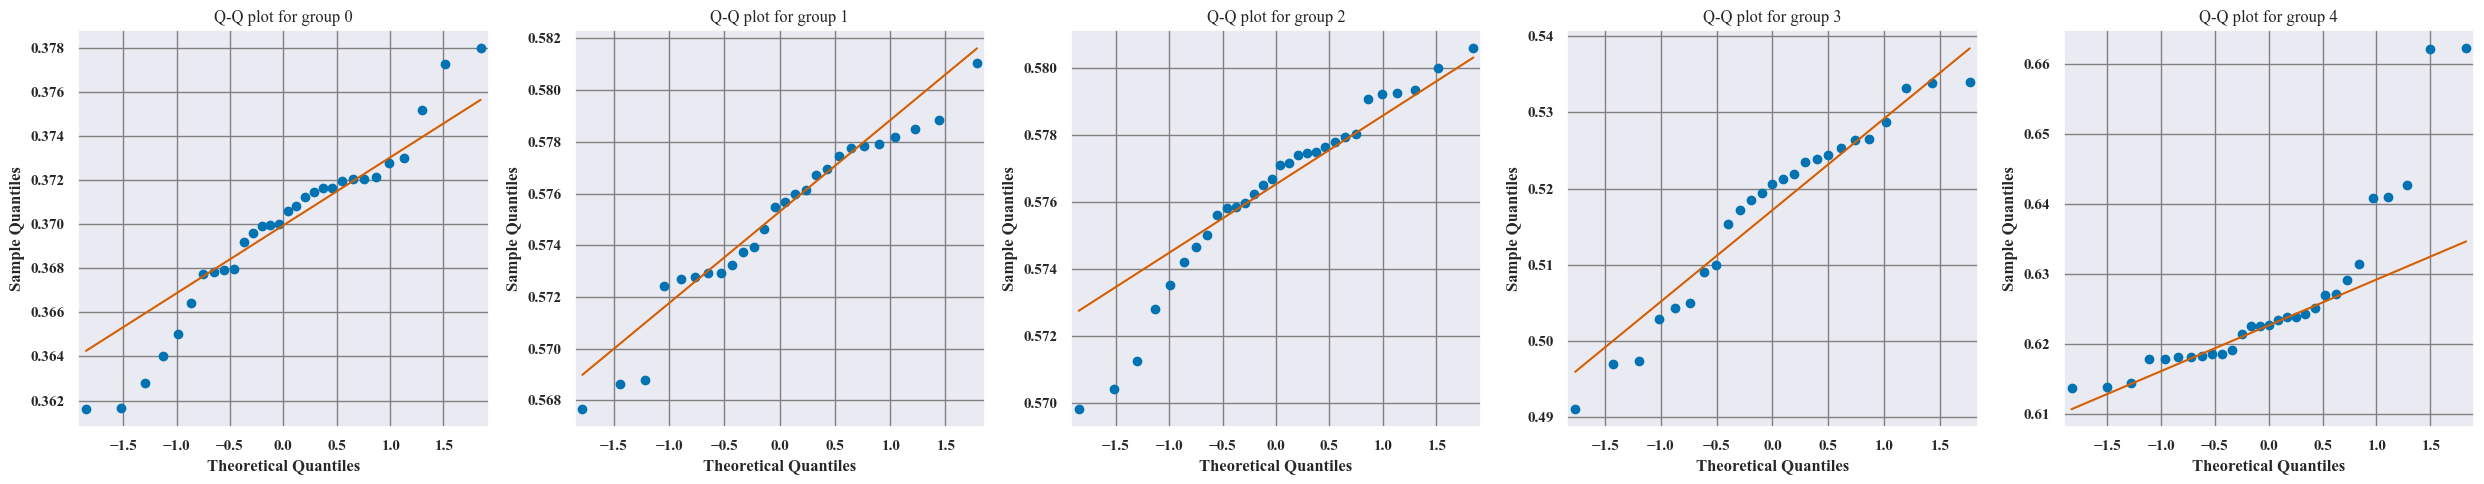

In [ ]:
dependent_variable = "energy"
independent_variable = "architecture"

test_assumptions(
    rq1_df.query("architecture == 'MobileNet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

###### Welch's ANOVA test

In [ ]:
pg.welch_anova(rq1_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,architecture,4,63.320702,15243.969805,1.089177e-93,0.99245


###### Games-Howell post-hoc test

In [ ]:
pg.pairwise_gameshowell(rq1_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,MobileNet V2,NASNet Mobile,0.369780,0.574952,-0.205172,0.000983,-208.700795,53.910447,1.110223e-14,-54.404605
1,MobileNet V2,ResNet50,0.369780,0.517213,-0.147433,0.002525,-58.394784,28.434610,3.552714e-15,-16.792406
2,MobileNet V2,VGG16,0.369780,0.626301,-0.256521,0.002431,-105.513740,33.571074,0.000000e+00,-27.496764
3,MobileNet V2,Xception,0.369780,0.576324,-0.206545,0.000885,-233.440087,50.809798,0.000000e+00,-59.491192
4,NASNet Mobile,ResNet50,0.574952,0.517213,0.057739,0.002503,23.070365,27.505758,0.000000e+00,6.473082
5,NASNet Mobile,VGG16,0.574952,0.626301,-0.051349,0.002408,-21.322163,32.407032,0.000000e+00,-5.409927
6,NASNet Mobile,Xception,0.574952,0.576324,-0.001373,0.000820,-1.674752,48.158284,4.587774e-01,-0.449159
7,ResNet50,VGG16,0.517213,0.626301,-0.109088,0.003348,-32.585034,51.277916,8.881784e-16,-8.742407
8,ResNet50,Xception,0.517213,0.576324,-0.059111,0.002466,-23.972917,26.012717,0.000000e+00,-6.961049
9,VGG16,Xception,0.626301,0.576324,0.049976,0.002370,21.088618,30.542392,3.996803e-15,5.504988


###### Kruskal-Wallis test

In [ ]:
result_rq11 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq11

,Source,ddof1,H,p-unc
Kruskal,architecture,4,127.126455,1.602604e-26


###### Eta-squared measure

In [ ]:
eta_squared(result_rq11["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.9120478124449753

###### Dunn's test

In [ ]:
p_values = sp.posthoc_dunn(
    rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm", sort=True
)

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,MobileNet V2,NASNet Mobile,ResNet50,VGG16,Xception
MobileNet V2,False,True,True,True,True
NASNet Mobile,True,False,True,True,False
ResNet50,True,True,False,True,True
VGG16,True,True,True,False,True
Xception,True,False,True,True,False


In [ ]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "MobileNet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"MobileNet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"MobileNet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"MobileNet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"MobileNet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

MobileNet V2 - NASNet Mobile effect size: (-1.0, 'large')
MobileNet V2 - Xception effect size: (-1.0, 'large')
MobileNet V2 - ResNet50 effect size: (-1.0, 'large')
MobileNet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (-0.24871794871794872, 'small')
NASNet Mobile - ResNet50 effect size: (1.0, 'large')
NASNet Mobile - VGG16 effect size: (-1.0, 'large')
Xception - ResNet50 effect size: (1.0, 'large')
Xception - VGG16 effect size: (-1.0, 'large')
ResNet50 - VGG16 effect size: (-1.0, 'large')


##### GPU usage
In this case, we observe that the data is not normally distributed. Therefore, we take the results from the Kruskal-Wallis test as the relevant ones.

Shapiro test for normality of group 0: W = 0.9209879040718079 and p-value 0.028453435748815536
Shapiro test for normality of group 1: W = 0.8396124243736267 and p-value 0.0009005153551697731
Shapiro test for normality of group 2: W = 0.9507325291633606 and p-value 0.17686785757541656
Shapiro test for normality of group 3: W = 0.9611562490463257 and p-value 0.43798255920410156
Shapiro test for normality of group 4: W = 0.8111292719841003 and p-value 0.00013311690418049693
Levene test for equal variances: W = 3.927364835728561 and p-value = 0.004765226917028142


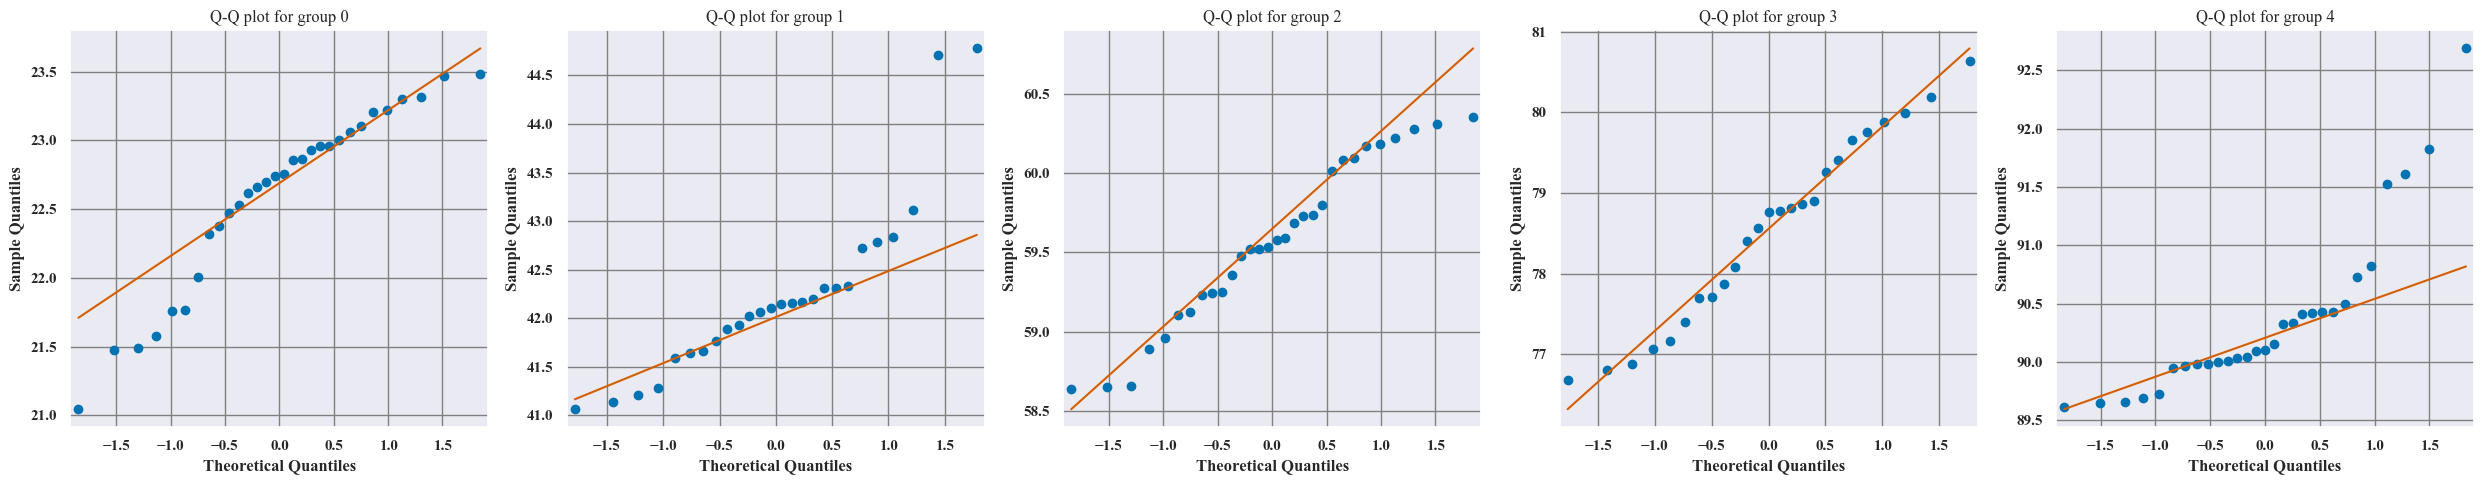

In [ ]:
dependent_variable = "gpu_usage"

test_assumptions(
    rq1_df.query("architecture == 'MobileNet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

###### Welch's ANOVA test

In [ ]:
pg.welch_anova(rq1_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,architecture,4,64.528362,39124.489648,2.039769e-108,0.998974


###### Games-Howell post-hoc test

In [ ]:
pg.pairwise_gameshowell(rq1_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,MobileNet V2,NASNet Mobile,22.601064,42.229507,-19.628442,0.213720,-91.841858,44.802625,0.000000e+00,-24.827785
1,MobileNet V2,ResNet50,22.601064,78.530723,-55.929658,0.260412,-214.773610,36.300415,4.440892e-16,-60.152857
2,MobileNet V2,VGG16,22.601064,90.369925,-67.768860,0.179230,-378.111412,56.012035,0.000000e+00,-97.329846
3,MobileNet V2,Xception,22.601064,59.566237,-36.965173,0.152265,-242.769109,55.184596,1.443290e-15,-61.868653
4,NASNet Mobile,ResNet50,42.229507,78.530723,-36.301216,0.291667,-124.461305,45.421060,0.000000e+00,-34.493022
5,NASNet Mobile,VGG16,42.229507,90.369925,-48.140418,0.222212,-216.641542,47.749359,2.997602e-15,-58.399421
6,NASNet Mobile,Xception,42.229507,59.566237,-17.336730,0.201096,-86.211309,38.587603,0.000000e+00,-23.630659
7,ResNet50,VGG16,78.530723,90.369925,-11.839202,0.267426,-44.270978,38.988323,0.000000e+00,-12.310932
8,ResNet50,Xception,78.530723,59.566237,18.964486,0.250155,75.810797,31.966943,0.000000e+00,21.527565
9,VGG16,Xception,90.369925,59.566237,30.803688,0.163971,187.860129,50.777594,1.332268e-15,48.540027


###### Kruskal-Wallis test

In [ ]:
result_rq11 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq11

,Source,ddof1,H,p-unc
Kruskal,architecture,4,133.354103,7.463900e-28


###### Eta-squared measure

In [ ]:
eta_squared(result_rq11["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.9581785432849268

###### Dunn's test

In [ ]:
p_values = sp.posthoc_dunn(
    rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm", sort=True
)

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,MobileNet V2,NASNet Mobile,ResNet50,VGG16,Xception
MobileNet V2,False,True,True,True,True
NASNet Mobile,True,False,True,True,True
ResNet50,True,True,False,True,True
VGG16,True,True,True,False,True
Xception,True,True,True,True,False


In [ ]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "MobileNet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"MobileNet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"MobileNet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"MobileNet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"MobileNet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

MobileNet V2 - NASNet Mobile effect size: (-1.0, 'large')
MobileNet V2 - Xception effect size: (-1.0, 'large')
MobileNet V2 - ResNet50 effect size: (-1.0, 'large')
MobileNet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (-1.0, 'large')
NASNet Mobile - ResNet50 effect size: (-1.0, 'large')
NASNet Mobile - VGG16 effect size: (-1.0, 'large')
Xception - ResNet50 effect size: (-1.0, 'large')
Xception - VGG16 effect size: (-1.0, 'large')
ResNet50 - VGG16 effect size: (-1.0, 'large')


#### RQ1.2 - Do gains in correctness achieved by energy-greedy architectures justify their increased energy consumption?

As we clearly see from the Q-Q plots, the F1-score data is not normally distributed. Therefore, we perform a Kruskal-Wallis test.

Shapiro test for normality of group 0: W = 0.5614897012710571 and p-value 2.5521618596258122e-08
Shapiro test for normality of group 1: W = 0.9575476050376892 and p-value 0.3455858528614044
Shapiro test for normality of group 2: W = 0.9610384106636047 and p-value 0.3292081356048584
Shapiro test for normality of group 3: W = 0.6999666094779968 and p-value 7.28050463294494e-06
Shapiro test for normality of group 4: W = 0.9783178567886353 and p-value 0.7939429879188538
Levene test for equal variances: W = 10.701102253559972 and p-value = 1.456111281113619e-07


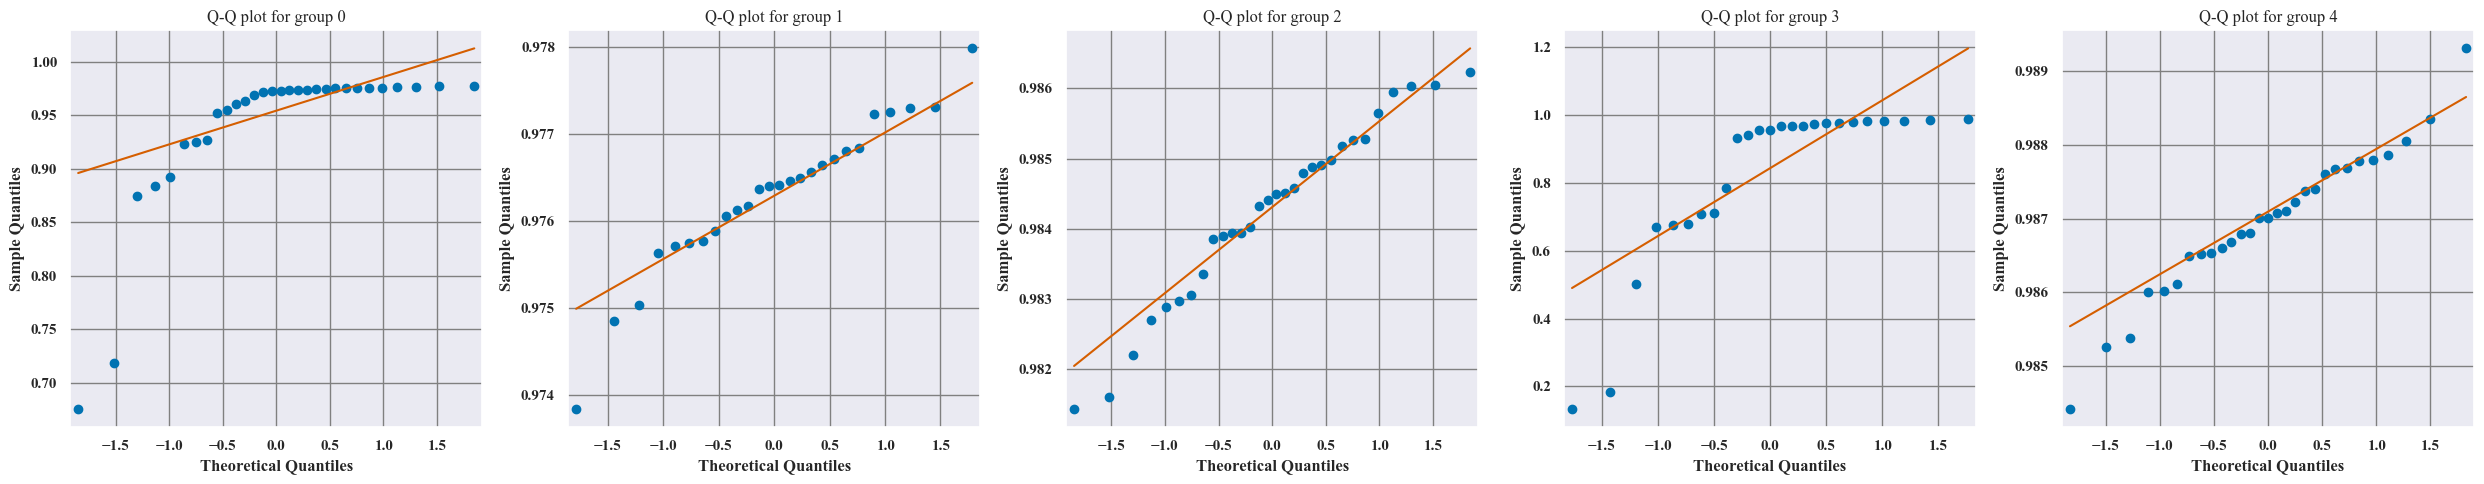

In [ ]:
dependent_variable = "f1-score"

test_assumptions(
    rq1_df.query("architecture == 'MobileNet V2'")[dependent_variable],
    rq1_df.query("architecture == 'NASNet Mobile'")[dependent_variable],
    rq1_df.query("architecture == 'Xception'")[dependent_variable],
    rq1_df.query("architecture == 'ResNet50'")[dependent_variable],
    rq1_df.query("architecture == 'VGG16'")[dependent_variable],
    nrows=1,
    ncols=5,
    figsize=(25, 5),
)

##### Kruskal-Wallis test

In [ ]:
result_rq12 = pg.kruskal(rq1_df, dv=dependent_variable, between=independent_variable)
result_rq12

,Source,ddof1,H,p-unc
Kruskal,architecture,4,108.292997,1.682645e-22


##### Eta-squared measure

In [ ]:
eta_squared(result_rq12["H"].item(), rq1_df[independent_variable].nunique(), rq1_df.shape[0])

0.772540717754484

##### Dunn's test

In [ ]:
p_values = sp.posthoc_dunn(rq1_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,MobileNet V2,NASNet Mobile,ResNet50,VGG16,Xception
MobileNet V2,False,False,False,True,True
NASNet Mobile,False,False,False,True,True
ResNet50,False,False,False,True,True
VGG16,True,True,True,False,True
Xception,True,True,True,True,False


In [ ]:
mobilenet_v2 = rq1_df[dependent_variable][rq1_df["architecture"] == "MobileNet V2"]
nasnet_mobile = rq1_df[dependent_variable][rq1_df["architecture"] == "NASNet Mobile"]
xception = rq1_df[dependent_variable][rq1_df["architecture"] == "Xception"]
resnet50 = rq1_df[dependent_variable][rq1_df["architecture"] == "ResNet50"]
vgg16 = rq1_df[dependent_variable][rq1_df["architecture"] == "VGG16"]

print(f"MobileNet V2 - NASNet Mobile effect size: {cliffs_delta(mobilenet_v2, nasnet_mobile)}")
print(f"MobileNet V2 - Xception effect size: {cliffs_delta(mobilenet_v2, xception)}")
print(f"MobileNet V2 - ResNet50 effect size: {cliffs_delta(mobilenet_v2, resnet50)}")
print(f"MobileNet V2 - VGG16 effect size: {cliffs_delta(mobilenet_v2, vgg16)}")
print(f"NASNet Mobile - Xception effect size: {cliffs_delta(nasnet_mobile, xception)}")
print(f"NASNet Mobile - ResNet50 effect size: {cliffs_delta(nasnet_mobile, resnet50)}")
print(f"NASNet Mobile - VGG16 effect size: {cliffs_delta(nasnet_mobile, vgg16)}")
print(f"Xception - ResNet50 effect size: {cliffs_delta(xception, resnet50)}")
print(f"Xception - VGG16 effect size: {cliffs_delta(xception, vgg16)}")
print(f"ResNet50 - VGG16 effect size: {cliffs_delta(resnet50, vgg16)}")

MobileNet V2 - NASNet Mobile effect size: (-0.7538461538461538, 'large')
MobileNet V2 - Xception effect size: (-1.0, 'large')
MobileNet V2 - ResNet50 effect size: (0.12, 'negligible')
MobileNet V2 - VGG16 effect size: (-1.0, 'large')
NASNet Mobile - Xception effect size: (-1.0, 'large')
NASNet Mobile - ResNet50 effect size: (0.4246153846153846, 'medium')
NASNet Mobile - VGG16 effect size: (-1.0, 'large')
Xception - ResNet50 effect size: (0.8346666666666667, 'large')
Xception - VGG16 effect size: (-0.9229885057471264, 'large')
ResNet50 - VGG16 effect size: (-0.953103448275862, 'large')


### RQ1.3 - How does the complexity of a DL architecture affect energy efficiency?

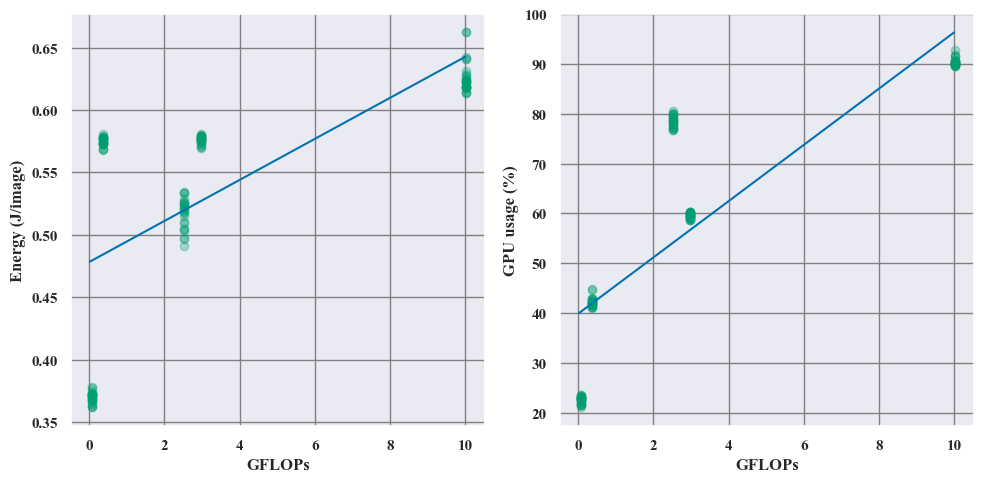

In [ ]:
grouped_df = (
    analysis_df_no_outliers.query("`training environment` != 'Local N'")
    .groupby(["training environment", "architecture"], as_index=False)
    .agg(GFLOPs=("GFLOPs", "first"), energy=("energy", "median"), gpu_usage=("gpu_usage", "median"))
)

_, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 5))

x = rq1_df.GFLOPs
y = rq1_df.energy

ax0.scatter(
    x,
    y,
    color=COLORS["Cloud"],
    alpha=0.3,
)

m, b = np.polyfit(x, y, 1)
samples = np.linspace(1e-2, 10, 100)
ax0.plot(samples, m * samples + b, color="b")

ax0.set_ylabel("Energy (J/image)")
ax0.set_xlabel("GFLOPs")

y = rq1_df.gpu_usage

ax1.scatter(
    x,
    y,
    color=COLORS["Cloud"],
    alpha=0.3,
)

ax1.set_ylabel("GPU usage (%)")
ax1.set_xlabel("GFLOPs")

# p1, p2 = np.polyfit(np.log(x), y, 1)
# ax1.plot(samples, p1 * np.log(samples) + p2, "r", label="logarithmic reg")

m, b = np.polyfit(x, y, 1)
ax1.plot(samples, m * samples + b, color="b", label="linear reg")
# ax1.legend()

if SAVE_FIGS:
    plt.savefig(os.path.join(FIGURES_DIR, f"cloud-energy-flops-regression.{FIGURES_FORMAT}"))

#### Correlation between FLOPs and Energy, and FLOPs and GPU usage

##### Local ML
Energy/FLOPs correlation

In [ ]:
stats.spearmanr(
    local_ml_energy_vs_gpu_usage_df.energy,
    local_ml_energy_vs_gpu_usage_df.GFLOPs,
    alternative="greater",
)

SignificanceResult(statistic=0.9766351736218772, pvalue=2.285340017087605e-102)

GPU usage/FLOPs correlation

In [ ]:
stats.spearmanr(
    local_ml_energy_vs_gpu_usage_df.gpu_usage,
    local_ml_energy_vs_gpu_usage_df.GFLOPs,
    alternative="greater",
)

SignificanceResult(statistic=0.9797741338970708, pvalue=5.129837057755373e-107)

##### Cloud
Energy/FLOPs correlation

In [ ]:
stats.spearmanr(rq1_df.energy, rq1_df.GFLOPs, alternative="greater")

SignificanceResult(statistic=0.8361354599854073, pvalue=4.125450735759262e-38)

GPU usage/FLOPs correlation

In [ ]:
stats.spearmanr(rq1_df.gpu_usage, rq1_df.GFLOPs, alternative="greater")

SignificanceResult(statistic=0.8873894360414593, pvalue=1.495000188124153e-48)

### RQ2 - Are local environments more energy-greedy than cloud environments when training DL models?

In [ ]:
rq2_df = pd.concat([local_n_mobilenet, local_ml_mobilenet_no_gpu_outliers, cloud_mobilenet])

#### Energy
The energy data for RQ2 is not normally distributed. Therefore, the relevant results are obtained from the Kruskal-Wallis test.

Shapiro test for normality of group 0: W = 0.8725419044494629 and p-value 0.0019092457368969917
Shapiro test for normality of group 1: W = 0.911083459854126 and p-value 0.015848223119974136
Shapiro test for normality of group 2: W = 0.9558686017990112 and p-value 0.24204814434051514
Levene test for equal variances: W = 0.004013687821183178 and p-value = 0.9959945406738412


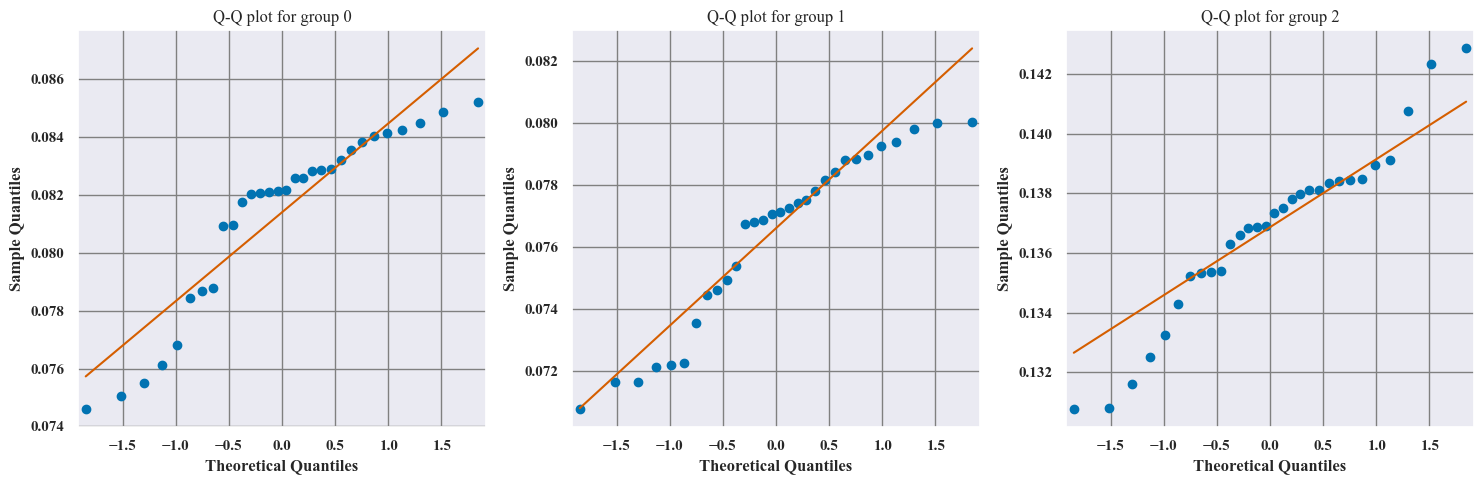

In [ ]:
independent_variable = "training environment"
dependent_variable = "energy"

test_assumptions(
    rq2_df.query("`training environment` == 'Local N'")[dependent_variable],
    rq2_df.query("`training environment` == 'Local ML'")[dependent_variable],
    rq2_df.query("`training environment` == 'Cloud'")[dependent_variable],
    nrows=1,
    ncols=3,
    figsize=(15, 5),
)

##### Welch's ANOVA test

In [ ]:
pg.welch_anova(rq2_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,training environment,2,57.927883,3816.916763,3.202956e-62,0.988733


##### Tukey post-hoc test

In [ ]:
pg.pairwise_gameshowell(rq2_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Cloud,Local ML,0.136753,0.076335,0.060418,0.000751,80.497734,57.893659,5.551115e-15,20.514498
1,Cloud,Local N,0.136753,0.081320,0.055433,0.000784,70.727193,57.889812,2.553513e-15,18.024518
2,Local ML,Local N,0.076335,0.081320,-0.004985,0.000768,-6.489192,57.570981,6.455982e-08,-1.653742


##### Kruskal-Wallis test

In [ ]:
result_rq21 = pg.kruskal(rq2_df, dv=dependent_variable, between=independent_variable)
result_rq21

,Source,ddof1,H,p-unc
Kruskal,training environment,2,69.849475,6.797970e-16


##### Eta-squared measure

In [ ]:
eta_squared(result_rq21["H"].item(), rq2_df[independent_variable].nunique(), rq2_df.shape[0])

0.7798790226376432

##### Dunn's test

In [ ]:
p_values = sp.posthoc_dunn(rq2_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,Cloud,Local ML,Local N
Cloud,False,True,True
Local ML,True,False,True
Local N,True,True,False


In [ ]:
local = rq2_df[dependent_variable][rq2_df["training environment"] == "Local N"]
local_ml = rq2_df[dependent_variable][rq2_df["training environment"] == "Local ML"]
Cloud = rq2_df[dependent_variable][rq2_df["training environment"] == "Cloud"]

print(f"Local - Local ML effect size: {cliffs_delta(local, local_ml)}")
print(f"Local - Cloud effect size: {cliffs_delta(local, Cloud)}")
print(f"Local ML - Cloud effect size: {cliffs_delta(local_ml, Cloud)}")

Local - Local ML effect size: (0.7288888888888889, 'large')
Local - Cloud effect size: (-1.0, 'large')
Local ML - Cloud effect size: (-1.0, 'large')


#### GPU usage
As with the energy data, GPU usage data is not normally distributed. Therefore, the relevant results are obtained from the Kruskal-Wallis test.


In [ ]:
local = rq2_df.gpu_usage[rq2_df["training environment"] == "Local N"]
local_ml = rq2_df.gpu_usage[rq2_df["training environment"] == "Local ML"]
Cloud = rq2_df.gpu_usage[rq2_df["training environment"] == "Cloud"]

dependent_variable = "gpu_usage"

Shapiro test for normality of group 0: W = 0.9337794780731201 and p-value 0.06192095950245857
Shapiro test for normality of group 1: W = 0.955195963382721 and p-value 0.23238784074783325
Shapiro test for normality of group 2: W = 0.9209879040718079 and p-value 0.028453435748815536
Levene test for equal variances: W = 15.169472968055345 and p-value = 2.2302448531200786e-06


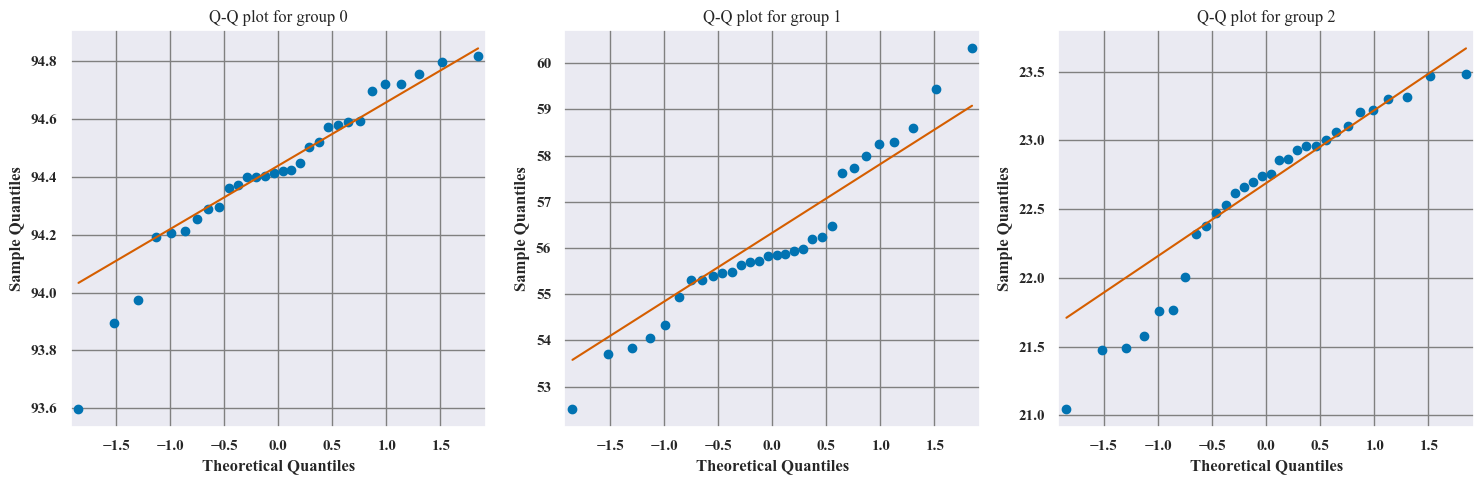

In [ ]:
test_assumptions(local, local_ml, Cloud, nrows=1, ncols=3, figsize=(15, 5))

##### Welch's ANOVA test

In [ ]:
pg.welch_anova(rq2_df, dv=dependent_variable, between=independent_variable)

,Source,ddof1,ddof2,F,p-unc,np2
0,training environment,2,45.022708,155853.634848,3.530936e-87,0.998665


##### Games-Howell post-hoc test

In [ ]:
pg.pairwise_gameshowell(rq2_df, dv=dependent_variable, between=independent_variable)

,A,B,mean(A),mean(B),diff,se,T,df,pval,hedges
0,Cloud,Local ML,22.601064,56.133512,-33.532447,0.341405,-98.218899,36.900852,0.000000e+00,-25.030660
1,Cloud,Local N,22.601064,94.414385,-71.813321,0.129185,-555.896548,38.815542,3.552714e-15,-141.667821
2,Local ML,Local N,56.133512,94.414385,-38.280874,0.323767,-118.235941,30.403486,9.992007e-16,-30.131916


##### Kruskal-Wallis test

In [ ]:
result_rq22 = pg.kruskal(rq2_df, dv=dependent_variable, between=independent_variable)
result_rq22

,Source,ddof1,H,p-unc
Kruskal,training environment,2,79.120879,6.593551e-18


##### Eta-squared measure

In [ ]:
eta_squared(result_rq22["H"].item(), rq2_df[independent_variable].nunique(), rq2_df.shape[0])

0.8864468864468865

##### Dunn's test

In [ ]:
p_values = sp.posthoc_dunn(rq2_df, val_col=dependent_variable, group_col=independent_variable, p_adjust="holm")

# Check which assumptions reject the null hypothesis.
p_values < 0.05

,Cloud,Local ML,Local N
Cloud,False,True,True
Local ML,True,False,True
Local N,True,True,False


In [ ]:
print(f"Local - Local ML effect size: {cliffs_delta(local, local_ml)}")
print(f"Local - Cloud effect size: {cliffs_delta(local, Cloud)}")
print(f"Local ML - Cloud effect size: {cliffs_delta(local_ml, Cloud)}")

Local - Local ML effect size: (1.0, 'large')
Local - Cloud effect size: (1.0, 'large')
Local ML - Cloud effect size: (1.0, 'large')
